In [1]:
import sys

sys.path.append('/user/rajaram/u13657/rltransfer')
import os

In [2]:
import pickle
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import os
import argparse
import random
import torch
from pathlib import Path
import gym
# sys.path.append(os.path.join(os.path.expanduser('~'),'rltransfer/PreferenceTransformer'))
# import wrappers
# from PreferenceTransformer.JaxPref.replay_buffer import get_d4rl_dataset
# from PreferenceTransformer.JaxPref.new_preference_reward_main import create_preference_dataset
# from PreferenceTransformer.JaxPref.sampler import TrajSampler
# from PreferenceTransformer.JaxPref import reward_transform as r_tf
# sys.path.append(os.path.join(os.path.expanduser("~"), "rltransfer/OfflineRL-Kit/run_example/"))

# from run_iql_infrewards import make_offlinedataset_fromargs

import argparse
import random

import gym
import d4rl

import numpy as np
import torch


from offlinerlkit.nets import MLP
from offlinerlkit.modules import ActorProb, Critic, DiagGaussian
from offlinerlkit.buffer import ReplayBuffer
from offlinerlkit.utils.logger import Logger, make_log_dirs
from offlinerlkit.policy_trainer import MFPolicyTrainer
from offlinerlkit.policy import IQLPolicy
import pickle
import os
import datetime

import sys

print("##########Python version##########")
print(sys.version)
sys.path.append(os.path.join(os.path.expanduser('~'),'rltransfer'))
import url_benchmark
from url_benchmark.pbrl.make_offlinedataset import make_offline_dataset, normalize
from PreferenceTransformer.get_PTdataset import make_env_and_dataset
import wandb
import yaml

sys.path.append(os.path.join(os.path.expanduser('~'),'rltransfer/PreferenceTransformer'))
from dataset_utils import D4RLDataset, reward_from_preference, reward_from_preference_transformer
import wrappers
import matplotlib.pyplot as plt
import numpy as np
import pickle


#########IMPORTED LOCALLY############


<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


######REGISTERING ENVIRONMENTS#####
##########Python version##########
3.10.9 (main, Mar  8 2023, 10:47:38) [GCC 11.2.0]


/opt/conda/lib/python3.10/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


## Make Tables

#### IQL Tables

In [3]:
import pandas as pd
import numpy as np
import wandb
from collections import defaultdict
from IPython.display import display

# Function to check if the crashed run has timestep > 900
def has_valid_timestep(run):
    for row in run.scan_history():
        if "timestep" in row and row["timestep"] > 900*1000:
            return True
    return False

# Function to get the results from wandb
def get_results(mistake_rate, use05, task, scriptLabel=False, srJobType='RandomSubseqs',jobTypeHopperSR=None):
    dataset_name = f"Percent100_05{use05}"
    if scriptLabel:
        dataset_name += '_scriptLabel'
    if mistake_rate > 0:
        dataset_name += f"_mistake{int(mistake_rate*100)}"
    
    group_name_gt = "GroundTruth"
    group_name_dppo = f"{dataset_name}_DPPOPolicy"
    group_name_pt = f"{dataset_name}_PreferenceTransformer"
    group_name_pt_adthighg = f"{dataset_name}_PreferenceTransformer"
    group_name_sr = f"{dataset_name}_SimilarityRewards"

    seeds = [231, 107, 93, 1, 123, 827, 67, 42]
    job_types_pt_adthighg = "ADTHighG"
    job_type_gt="NewNorm"
    job_types_sr = srJobType
    if jobTypeHopperSR is not None and task=='hopper-medium-expert-v2':
        job_types_sr=jobTypeHopperSR
    
    # Define a helper to fetch relevant runs
    def fetch_runs(project_name, group_name, job_type=None):
        #print ("Fetching runs for {} {} {}".format(project_name,group_name,job_type))
        api = wandb.Api()
        # Build filters for wandb
        filters = {'group': group_name}
        # If job_type_filter is None, only fetch runs with jobType == null
        if job_type is None:
            filters['jobType'] = {'$eq': None}
        else:
            filters['jobType'] = {'$contains': job_type}


        runs = api.runs(project_name, filters=filters)
        #print(runs)
        # Filter runs by seed and ensure there are exactly 8 completed runs
        
        seed_count = defaultdict(int)  # Track the count of each seed found

        for run in runs:
            if run.state == "finished" or (run.state == "crashed" and has_valid_timestep(run)):
                # Check if the run name includes 'seed{seed}_' for the correct seed
                for seed in seeds:
                    if f"seed{seed}_" in run.name:
                        seed_count[seed] += 1
                        break  # No need to check further once we find a matching seed

        # Ensure that each seed appears exactly once (i.e., no duplicate or missing seeds)
        for seed, count in seed_count.items():
            if count == 0:
                print(f"Warning: In project '{run.project}', group '{run.group}', seed {seed} is missing.")
            elif count > 1:
                print(f"Warning: In project '{run.project}', group '{run.group}', seed {seed} was run {count} times.")

        
        if len(runs) == 8 and len(seed_count)==8 and all(value == 1 for value in seed_count.values()):
            return runs
        else:
            return None
            
        
        
    
    # Function to extract max mean and corresponding std
    def extract_max_mean_std(runs):
        all_means = []
        all_stds = []

        for run in runs:
            mean_rewards = []
            std_rewards = []
            for row in run.scan_history():
                if "eval/running_epRewards_mean" in row:
                    mean=row["eval/running_epRewards_mean"]
                    std=row["eval/running_epRewards_std"]
                    if mean is not None and std is not None:
                        mean_rewards.append(mean)
                        std_rewards.append(std)

            all_means.append(mean_rewards)
            all_stds.append(std_rewards)
        all_means = np.array(all_means)  
        all_stds = np.array(all_stds)
        
        mean_across_seeds = np.mean(all_means, axis=0)

        all_stds_corrected = all_stds * np.sqrt(80 / 79) 
        within_seed_var = np.mean(all_stds_corrected ** 2, axis=0)  
        across_seed_var = np.var(all_means, axis=0, ddof=1)
        total_std = np.sqrt(within_seed_var + across_seed_var)

        max_idx = np.argmax(mean_across_seeds)
        max_value = mean_across_seeds[max_idx]
        max_std = total_std[max_idx]

        return max_value, max_std

    # Fetch results for each method (PT, PT+ADT, SR)
    project_name=f"IQL_{task}"
    project_nameGT=f"IQL_{task}" #ground truth IQL was only saved in the base project, but of course it does not change based on the dataset
    if scriptLabel:
         project_name += "_scriptLabel"
    if mistake_rate > 0:
        project_name += "_error"
    
    gt_runs = fetch_runs(project_nameGT, group_name_gt,job_type=job_type_gt)
    dppo_runs = fetch_runs(project_name, group_name_dppo)
    pt_runs = fetch_runs(project_name, group_name_pt)
    pt_adthighg_runs = fetch_runs(project_name, group_name_pt_adthighg, job_type=job_types_pt_adthighg)
    sr_runs = fetch_runs(project_name, group_name_sr, job_type=job_types_sr)

    results = defaultdict(lambda: defaultdict(str))
    # Process GT results
    if gt_runs:
        max_value, max_std = extract_max_mean_std(gt_runs)
        results['TaskReward'][task] = f"{max_value:.2f} ± {max_std:.2f}"
    
    # Process PT results
    if pt_runs:
        max_value, max_std = extract_max_mean_std(pt_runs)
        results['PT'][task] = f"{max_value:.2f} ± {max_std:.2f}"
    
    # Process DPPO results
    if dppo_runs:
        print(dppo_runs)
        max_value, max_std = extract_max_mean_std(dppo_runs)
        results['DPPO'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    # Process PT+ADT results
    if pt_adthighg_runs:
        max_value, max_std = extract_max_mean_std(pt_adthighg_runs)
        results['PT+ADT'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    # Process SR results
    if sr_runs:
        max_value, max_std = extract_max_mean_std(sr_runs)
        results['SR'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    return results



# Initialize your table

def show_table(mistake_rate, use05, scriptLabel=False,srJobType='RandomSubseqs', jobTypeHopperSR=None):
    tasks = ['hopper-medium-replay-v2', 'hopper-medium-expert-v2', 'walker2d-medium-replay-v2', 'walker2d-medium-expert-v2']

    table_data = []  # Initialize the table data for each combination
    for task in tasks:
        row = {'Task': task} #'Mistake Rate': mistake_rate, 'Incl Neutral': use05
        
        results = get_results(mistake_rate, use05, task, scriptLabel=scriptLabel, srJobType=srJobType,jobTypeHopperSR=jobTypeHopperSR)
        
        for method in ['TaskReward','PT', 'PT+ADT', 'DPPO','SR']:
            value = results.get(method, {}).get(task, '')
            row[f'{method}'] = value

        table_data.append(row)

    # Convert to a pandas DataFrame for this specific combination
    df = pd.DataFrame(table_data)

    # Display each table to the user
    display(df)


#### Script Label

In [5]:
show_table(0, use05=True, scriptLabel=True, srJobType='moreSeqs')

<Runs rlunigoe/IQL_hopper-medium-replay-v2_scriptLabel>
<Runs rlunigoe/IQL_hopper-medium-expert-v2_scriptLabel>
<Runs rlunigoe/IQL_walker2d-medium-replay-v2_scriptLabel>
<Runs rlunigoe/IQL_walker2d-medium-expert-v2_scriptLabel>


Task     TaskReward             PT         PT+ADT  \
0    hopper-medium-replay-v2  92.26 ± 13.55  38.43 ± 19.78  70.55 ± 33.76   
1    hopper-medium-expert-v2  80.82 ± 44.49  63.03 ± 34.51  86.96 ± 35.91   
2  walker2d-medium-replay-v2  77.53 ± 15.50  76.69 ± 13.95  76.40 ± 11.04   
3  walker2d-medium-expert-v2  107.57 ± 8.46  109.80 ± 1.88  109.74 ± 1.02   

             DPPO             SR  
0   32.75 ± 22.56   87.43 ± 8.40  
1  102.19 ± 24.43  96.43 ± 27.86  
2   52.27 ± 24.74   76.51 ± 6.40  
3   108.81 ± 0.36  108.88 ± 4.63

#### Human Label, 05 True

In [6]:
show_table(0, use05=True, scriptLabel=False, srJobType='RandomSubseqs',jobTypeHopperSR='moreSeqs')

<Runs rlunigoe/IQL_hopper-medium-replay-v2>
<Runs rlunigoe/IQL_hopper-medium-expert-v2>
<Runs rlunigoe/IQL_walker2d-medium-replay-v2>
<Runs rlunigoe/IQL_walker2d-medium-expert-v2>


Task     TaskReward             PT         PT+ADT  \
0    hopper-medium-replay-v2  92.26 ± 13.55  74.48 ± 21.35  80.24 ± 16.08   
1    hopper-medium-expert-v2  80.82 ± 44.49  89.64 ± 28.32  71.33 ± 40.56   
2  walker2d-medium-replay-v2  77.53 ± 15.50   74.43 ± 8.04   75.68 ± 8.33   
3  walker2d-medium-expert-v2  107.57 ± 8.46  109.74 ± 1.07  109.98 ± 1.00   

             DPPO             SR  
0   68.98 ± 18.39   84.68 ± 3.13  
1  108.09 ± 10.80  80.45 ± 48.11  
2   47.21 ± 27.96   78.21 ± 5.76  
3   108.73 ± 0.43  108.35 ± 5.38

#### Human Label, use 05 False

In [7]:
show_table(0, False, scriptLabel=False, srJobType='RandomSubseqs')

<Runs rlunigoe/IQL_hopper-medium-replay-v2>
<Runs rlunigoe/IQL_hopper-medium-expert-v2>
<Runs rlunigoe/IQL_walker2d-medium-replay-v2>
<Runs rlunigoe/IQL_walker2d-medium-expert-v2>


Task     TaskReward             PT         PT+ADT  \
0    hopper-medium-replay-v2  92.26 ± 13.55   86.67 ± 4.65   83.06 ± 8.76   
1    hopper-medium-expert-v2  80.82 ± 44.49  59.90 ± 46.19  74.53 ± 41.71   
2  walker2d-medium-replay-v2  77.53 ± 15.50   75.14 ± 3.92   76.69 ± 6.50   
3  walker2d-medium-expert-v2  107.57 ± 8.46  110.09 ± 4.57  109.61 ± 2.21   

            DPPO             SR  
0  70.18 ± 19.88   84.43 ± 4.30  
1  108.88 ± 9.50  80.93 ± 43.85  
2  47.87 ± 27.59   77.91 ± 7.20  
3  108.77 ± 0.37  108.91 ± 3.44

#### Comparison Plots Human and Script

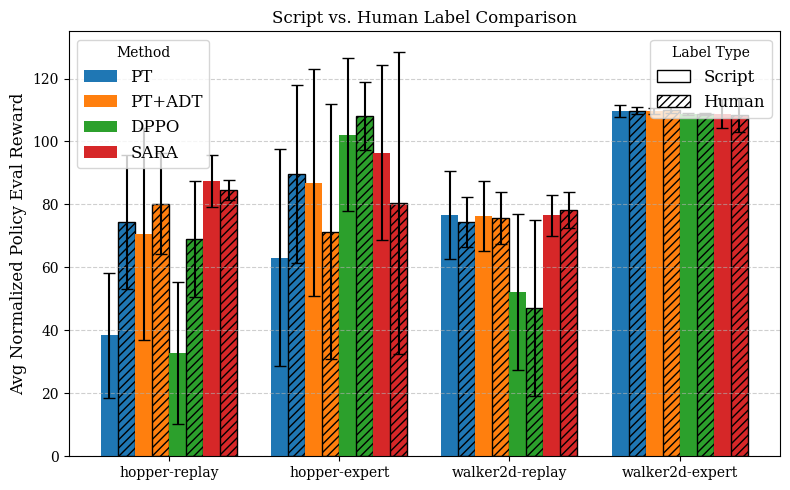

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Full task IDs (for data) and shortened labels (for x-axis)
tasks_full = [
    "hopper-medium-replay-v2",
    "hopper-medium-expert-v2",
    "walker2d-medium-replay-v2",
    "walker2d-medium-expert-v2"
]
tasks_short = ["hopper-replay", "hopper-expert", "walker2d-replay", "walker2d-expert"]

# 2) Dataset labels (legend) and the legend title
table_labels = ["Script", "Human"]
legend_title = "Label Type"

# 3) Methods (with SR renamed to SARA) and colors
methods = ["PT", "PT+ADT", "DPPO", "SARA"]
colors = plt.get_cmap("tab10").colors[:len(methods)]

# 4) Data for Script Teacher
means_script = {
    "PT":     [38.43, 63.03, 76.69, 109.80],
    "PT+ADT": [70.55, 86.96, 76.40, 109.74],
    "DPPO":   [32.75,102.19, 52.27, 108.81],
    "SARA":   [87.43, 96.43, 76.51, 108.88],
}
stds_script = {
    "PT":     [19.78, 34.51, 13.95,  1.88],
    "PT+ADT": [33.76, 35.91, 11.04,  1.02],
    "DPPO":   [22.56, 24.43, 24.74,  0.36],
    "SARA":   [ 8.40, 27.86,  6.40,  4.63],
}

# 5) Data for Human Teacher
means_human = {
    "PT":     [74.48, 89.64, 74.43, 109.74],
    "PT+ADT": [80.24, 71.33, 75.68, 109.98],
    "DPPO":   [68.98,108.09, 47.21, 108.73],
    "SARA":   [84.68, 80.45, 78.21, 108.35],
}
stds_human = {
    "PT":     [21.35, 28.32,  8.04,  1.07],
    "PT+ADT": [16.08, 40.56,  8.33,  1.00],
    "DPPO":   [18.39, 10.80, 27.96,  0.43],
    "SARA":   [ 3.13, 48.11,  5.76,  5.38],
}

# 6) Compute bar positions
x = np.arange(len(tasks_full))
n_methods = len(methods)
n_tables = 2
total_width = 0.8
bar_width = total_width / (n_methods * n_tables)

fig, ax = plt.subplots(figsize=(8, 5))

for i, method in enumerate(methods):
    center = (i - (n_methods - 1)/2) * n_tables * bar_width
    pos_script = x + center - bar_width/2
    pos_human  = x + center + bar_width/2

    # Script Teacher: solid fill
    ax.bar(
        pos_script,
        means_script[method],
        yerr=stds_script[method],
        width=bar_width,
        color=colors[i],
        capsize=4
    )
    # Human Teacher: hatched
    ax.bar(
        pos_human,
        means_human[method],
        yerr=stds_human[method],
        width=bar_width,
        color=colors[i],
        hatch='////',
        edgecolor='black',
        capsize=4
    )

# 7) Legends
method_patches = [
    Patch(facecolor=colors[i], label=methods[i]) 
    for i in range(n_methods)
]
leg1 = ax.legend(
    handles=method_patches,
    title="Method",
    loc="upper left"
)

table_patches = [
    Patch(facecolor="white", edgecolor="black", label=table_labels[0]),
    Patch(facecolor="white", edgecolor="black", hatch='////', label=table_labels[1])
]
leg2 = ax.legend(
    handles=table_patches,
    title=legend_title,
    loc="upper right"
)

ax.add_artist(leg1)

# 8) Final formatting
ax.set_xticks(x)
ax.set_xticklabels(tasks_short, rotation=0, ha="center")
ax.set_ylabel("Avg Normalized Policy Eval Reward")
ax.set_title("Script vs. Human Label Comparison")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


#### Comparison Plots Incl and Excl Neutra;

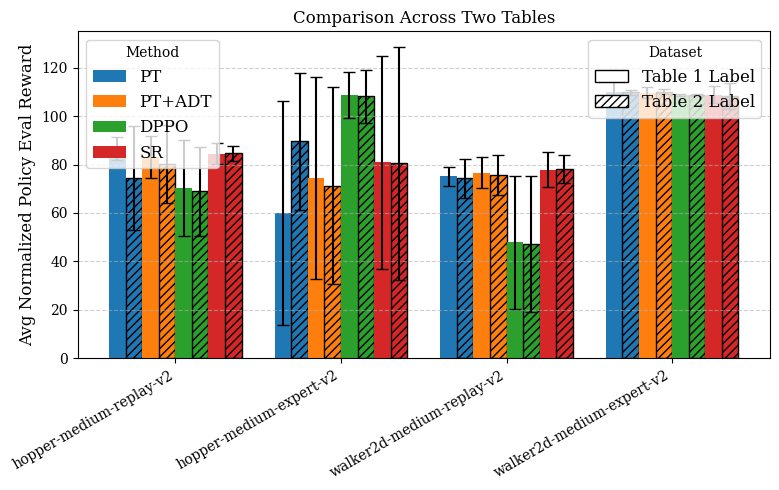

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Your tasks and table labels
tasks = [
    "hopper-medium-replay-v2",
    "hopper-medium-expert-v2",
    "walker2d-medium-replay-v2",
    "walker2d-medium-expert-v2"
]
table_labels = ["Table 1 Label", "Table 2 Label"]  # ← customize these

# 2) Methods + a clean, colorblind-Friendly palette
methods = ["PT", "PT+ADT", "DPPO", "SR"]
colors = plt.get_cmap("tab10").colors[:len(methods)]

# 3) Means & stds for each table (from your two DataFrames)
means1 = {
    "PT":     [86.67,  59.90,  75.14, 110.09],
    "PT+ADT": [83.06,  74.53,  76.69, 109.61],
    "DPPO":   [70.18, 108.88,  47.87, 108.77],
    "SR":     [84.43,  80.93,  77.91, 108.91],
}
stds1 = {
    "PT":     [ 4.65, 46.19,  3.92,  4.57],
    "PT+ADT": [ 8.76, 41.71,  6.50,  2.21],
    "DPPO":   [19.88,  9.50, 27.59,  0.37],
    "SR":     [ 4.30, 43.85,  7.20,  3.40],
}

means2 = {
    "PT":     [74.48,  89.64,  74.43, 109.74],
    "PT+ADT": [80.24,  71.33,  75.68, 109.98],
    "DPPO":   [68.98, 108.09,  47.21, 108.73],
    "SR":     [84.68,  80.45,  78.21, 108.35],
}
stds2 = {
    "PT":     [21.35, 28.32,  8.04,  1.07],
    "PT+ADT": [16.08, 40.56,  8.33,  1.00],
    "DPPO":   [18.39, 10.80, 27.96,  0.43],
    "SR":     [ 3.13, 48.11,  5.76,  5.38],
}

# 4) Compute bar positions
x = np.arange(len(tasks))
n_methods = len(methods)
n_tables = 2
total_width = 0.8
bar_width = total_width / (n_methods * n_tables)  # smaller bars to fit both tables

fig, ax = plt.subplots(figsize=(8, 5))

for i, method in enumerate(methods):
    # center block for this method
    block_center = (i - (n_methods - 1)/2) * n_tables * bar_width
    # two positions: table1 just left, table2 just right
    pos1 = x + block_center - bar_width/2
    pos2 = x + block_center + bar_width/2

    # plot table1
    ax.bar(
        pos1, 
        means1[method], 
        yerr=stds1[method], 
        width=bar_width,
        color=colors[i],
        capsize=4
    )
    # plot table2 with hatch
    ax.bar(
        pos2, 
        means2[method], 
        yerr=stds2[method], 
        width=bar_width,
        color=colors[i],
        hatch='////',
        edgecolor='black',
        capsize=4
    )

# 5) Legends
# Method legend (colors)
method_patches = [Patch(facecolor=colors[i], label=methods[i]) 
                  for i in range(n_methods)]
leg1 = ax.legend(
    handles=method_patches, 
    title="Method", 
    loc="upper left"
)

# Table legend (hatch)
table_patches = [
    Patch(facecolor="white", edgecolor="black", label=table_labels[0]),
    Patch(facecolor="white", edgecolor="black", hatch='////', label=table_labels[1])
]
leg2 = ax.legend(
    handles=table_patches, 
    title="Dataset", 
    loc="upper right"
)

ax.add_artist(leg1)

# 6) Final formatting
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=30, ha="right")
ax.set_ylabel("Avg Normalized Policy Eval Reward")
ax.set_title("Comparison Across Two Tables")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


#### Comparison: Human True with Mistake

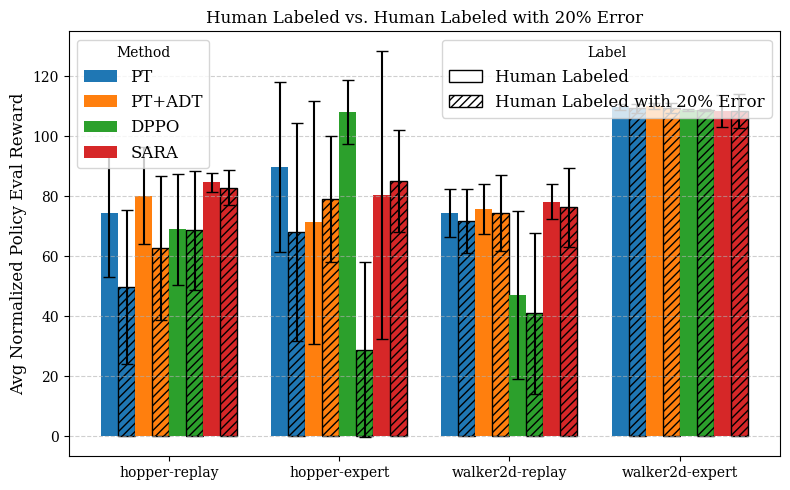

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Full task IDs (for data) and shortened labels (for x-axis)
tasks_full = [
    "hopper-medium-replay-v2",
    "hopper-medium-expert-v2",
    "walker2d-medium-replay-v2",
    "walker2d-medium-expert-v2"
]
tasks_short = ["hopper-replay", "hopper-expert", "walker2d-replay", "walker2d-expert"]

# 2) Dataset labels (legend) and the legend title
table_labels = ["Human Labeled", "Human Labeled with 20% Error"]
legend_title = "Label"

# 3) Methods (with SR renamed to SARA) and colors
methods = ["PT", "PT+ADT", "DPPO", "SARA"]
colors = plt.get_cmap("tab10").colors[:len(methods)]

# 4) Data for Human Labeled
means_hl = {
    "PT":     [74.48, 89.64, 74.43, 109.74],
    "PT+ADT": [80.24, 71.33, 75.68, 109.98],
    "DPPO":   [68.98,108.09, 47.21, 108.73],
    "SARA":   [84.68, 80.45, 78.21, 108.35],
}
stds_hl = {
    "PT":     [21.35, 28.32,  8.04,  1.07],
    "PT+ADT": [16.08, 40.56,  8.33,  1.00],
    "DPPO":   [18.39, 10.80, 27.96,  0.43],
    "SARA":   [ 3.13, 48.11,  5.76,  5.38],
}

# 5) Data for Human Labeled with 20% Error
means_hl_err = {
    "PT":     [49.77, 68.14, 71.73, 109.37],
    "PT+ADT": [62.87, 79.02, 74.42, 109.53],
    "DPPO":   [68.67, 28.92, 41.00, 108.78],
    "SARA":   [82.94, 85.16, 76.29, 108.37],
}
stds_hl_err = {
    "PT":     [25.68, 36.23, 10.74,  1.45],
    "PT+ADT": [24.04, 20.95, 12.55,  1.63],
    "DPPO":   [19.77, 29.11, 26.84,  0.38],
    "SARA":   [ 5.80, 17.01, 13.20,  5.68],
}

# 6) Compute bar positions
x = np.arange(len(tasks_full))
n_methods = len(methods)
n_tables = 2
total_width = 0.8
bar_width = total_width / (n_methods * n_tables)

fig, ax = plt.subplots(figsize=(8, 5))

for i, method in enumerate(methods):
    center = (i - (n_methods - 1)/2) * n_tables * bar_width
    pos_hl     = x + center - bar_width/2
    pos_hl_err = x + center + bar_width/2

    # Human Labeled (solid fill)
    ax.bar(
        pos_hl,
        means_hl[method],
        yerr=stds_hl[method],
        width=bar_width,
        color=colors[i],
        capsize=4
    )
    # Human Labeled w/ 20% Error (hatched)
    ax.bar(
        pos_hl_err,
        means_hl_err[method],
        yerr=stds_hl_err[method],
        width=bar_width,
        color=colors[i],
        hatch='////',
        edgecolor='black',
        capsize=4
    )

# 7) Legends
method_patches = [
    Patch(facecolor=colors[i], label=methods[i]) 
    for i in range(n_methods)
]
leg1 = ax.legend(
    handles=method_patches,
    title="Method",
    loc="upper left"
)

table_patches = [
    Patch(facecolor="white", edgecolor="black", label=table_labels[0]),
    Patch(facecolor="white", edgecolor="black", hatch='////', label=table_labels[1])
]
leg2 = ax.legend(
    handles=table_patches,
    title=legend_title,
    loc="upper right"
)

ax.add_artist(leg1)

# 8) Final formatting (horizontal x‐labels)
ax.set_xticks(x)
ax.set_xticklabels(tasks_short, rotation=0, ha="center")
ax.set_ylabel("Avg Normalized Policy Eval Reward")
ax.set_title("Human Labeled vs. Human Labeled with 20% Error")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


#### Mistake

In [8]:
show_table(0.2, True, scriptLabel=False, srJobType='RandomSubseqs')

<Runs rlunigoe/IQL_hopper-medium-replay-v2_error>
<Runs rlunigoe/IQL_hopper-medium-expert-v2_error>
<Runs rlunigoe/IQL_walker2d-medium-replay-v2_error>
<Runs rlunigoe/IQL_walker2d-medium-expert-v2_error>


Task     TaskReward             PT         PT+ADT  \
0    hopper-medium-replay-v2  92.26 ± 13.55  49.77 ± 25.68  62.87 ± 24.04   
1    hopper-medium-expert-v2  80.82 ± 44.49  68.14 ± 36.23  79.02 ± 20.95   
2  walker2d-medium-replay-v2  77.53 ± 15.50  71.73 ± 10.74  74.42 ± 12.55   
3  walker2d-medium-expert-v2  107.57 ± 8.46  109.37 ± 1.45  109.53 ± 1.63   

            DPPO             SR  
0  68.67 ± 19.77   82.94 ± 5.80  
1  28.92 ± 29.11  85.16 ± 17.01  
2  41.00 ± 26.84  76.29 ± 13.20  
3  108.78 ± 0.38  108.37 ± 5.68

## Correlation with Ground Truth Rewards and Number Outliers

## Kitchen and Pen 

#### Table Code

In [74]:
import pandas as pd
import numpy as np
import wandb
from collections import defaultdict
from IPython.display import display

# Function to check if the crashed run has timestep > 900
def has_valid_timestep(run):
    for row in run.scan_history():
        if "timestep" in row and row["timestep"] > 900*1000:
            return True
    return False

# Function to get the results from wandb
def get_results(mistake_rate, use05, task, scriptLabel=False, groupJobDict=None):
    dataset_name = f"Percent100_05{use05}"
    if scriptLabel:
        dataset_name += '_scriptLabel'
    if mistake_rate > 0:
        dataset_name += f"_mistake{int(mistake_rate*100)}"
    
    group_name_gt = "GroundTruth"
    group_name_dppo = f"{dataset_name}_DPPOPolicy"
    group_name_pt = f"{dataset_name}_PreferenceTransformer"
    group_name_pt_adthighg = f"{dataset_name}_PreferenceTransformer"
    group_name_sr = f"{dataset_name}_SimilarityRewards"
    
    jobTypeGT=groupJobDict["GroundTruth"]
    jobTypeDPPO=groupJobDict["DPPO"]
    jobTypePT=groupJobDict["PT"]
    jobTypePTADT=groupJobDict["PTADT"]
    jobTypeSR=groupJobDict["SR"]

    seeds = [231, 107, 93, 1, 123, 827, 67, 42]

    
    # Define a helper to fetch relevant runs
    def fetch_runs(project_name, group_name, job_type):
        api = wandb.Api()
        # Build filters for wandb
        filters = {'group': group_name}
        filters['jobType'] = {'$eq': job_type}
        


        runs = api.runs(project_name, filters=filters)
        #print(runs)
        # Filter runs by seed and ensure there are exactly 8 completed runs
        
        seed_count = defaultdict(int)  # Track the count of each seed found

        for run in runs:
            if run.state == "finished" or (run.state == "crashed" and has_valid_timestep(run)):
                # Check if the run name includes 'seed{seed}_' for the correct seed
                for seed in seeds:
                    if f"seed{seed}_" in run.name:
                        seed_count[seed] += 1
                        break  # No need to check further once we find a matching seed

        # Ensure that each seed appears exactly once (i.e., no duplicate or missing seeds)
        for seed, count in seed_count.items():
            if count == 0:
                print(f"Warning: In project '{run.project}', group '{run.group}', seed {seed} is missing.")
            elif count > 1:
                print(f"Warning: In project '{run.project}', group '{run.group}', seed {seed} was run {count} times.")

        
        if len(runs) == 8 and len(seed_count)==8 and all(value == 1 for value in seed_count.values()):
            return runs
        else:
            return None
            
        
        
    
    # Function to extract max mean and corresponding std
    def extract_max_mean_std(runs):
        all_means = []
        all_stds = []

        for run in runs:
            mean_rewards = []
            std_rewards = []
            for row in run.scan_history():
                if "eval/running_epRewards_mean" in row:
                    mean=row["eval/running_epRewards_mean"]
                    std=row["eval/running_epRewards_std"]
                    if mean is not None and std is not None:
                        mean_rewards.append(mean)
                        std_rewards.append(std)

            all_means.append(mean_rewards)
            all_stds.append(std_rewards)
        all_means = np.array(all_means)  
        all_stds = np.array(all_stds)
        
        mean_across_seeds = np.mean(all_means, axis=0)

        all_stds_corrected = all_stds * np.sqrt(80 / 79) 
        within_seed_var = np.mean(all_stds_corrected ** 2, axis=0)  
        across_seed_var = np.var(all_means, axis=0, ddof=1)
        total_std = np.sqrt(within_seed_var + across_seed_var)

        max_idx = np.argmax(mean_across_seeds)
        max_value = mean_across_seeds[max_idx]
        max_std = total_std[max_idx]

        return max_value, max_std

    # Fetch results for each method (PT, PT+ADT, SR)
    project_name=f"IQL_{task}"
    project_nameGT=f"IQL_{task}" #ground truth IQL was only saved in the base project, but of course it does not change based on the dataset
    if scriptLabel:
         project_name += "_scriptLabel"
    if mistake_rate > 0:
        project_name += "_error"
    
    gt_runs = fetch_runs(project_nameGT, group_name_gt,job_type=jobTypeGT)
    dppo_runs = fetch_runs(project_name, group_name_dppo,job_type=jobTypeDPPO)
    pt_runs = fetch_runs(project_name, group_name_pt,job_type=jobTypePT)
    pt_adthighg_runs = fetch_runs(project_name, group_name_pt_adthighg, job_type=jobTypePTADT)
    sr_runs = fetch_runs(project_name, group_name_sr, job_type=jobTypeSR)

    results = defaultdict(lambda: defaultdict(str))
    # Process GT results
    if gt_runs:
        max_value, max_std = extract_max_mean_std(gt_runs)
        results['TaskReward'][task] = f"{max_value:.2f} ± {max_std:.2f}"
    
    # Process PT results
    if pt_runs:
        max_value, max_std = extract_max_mean_std(pt_runs)
        results['PT'][task] = f"{max_value:.2f} ± {max_std:.2f}"
    
    # Process DPPO results
    if dppo_runs:
        print(dppo_runs)
        max_value, max_std = extract_max_mean_std(dppo_runs)
        results['DPPO'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    # Process PT+ADT results
    if pt_adthighg_runs:
        max_value, max_std = extract_max_mean_std(pt_adthighg_runs)
        results['PT+ADT'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    # Process SR results
    if sr_runs:
        max_value, max_std = extract_max_mean_std(sr_runs)
        results['SR'][task] = f"{max_value:.2f} ± {max_std:.2f}"

    return results



# Initialize your table

def show_table(mistake_rate, use05, scriptLabel=False,groupJobDict=None):
    tasks = ['kitchen-partial-v0', 'kitchen-mixed-v0']#['kitchen-partial-v0', 'kitchen-mixed-v0', 'pen-human-v1', 'pen-cloned-v1']

    table_data = []  # Initialize the table data for each combination
    for task in tasks:
        row = {'Task': task} #'Mistake Rate': mistake_rate, 'Incl Neutral': use05
        
        results = get_results(mistake_rate, use05, task, scriptLabel=scriptLabel,groupJobDict=groupJobDict)
        
        for method in ['TaskReward','PT', 'PT+ADT', 'DPPO','SR']:
            value = results.get(method, {}).get(task, '')
            row[f'{method}'] = value

        table_data.append(row)

    # Convert to a pandas DataFrame for this specific combination
    df = pd.DataFrame(table_data)

    # Display each table to the user
    display(df)


### Pen

In [37]:
groupJobDict={'GroundTruth':"NewNorm", "DPPO":None, "PT":None,"PTADT":"ADTHighG","SR": 'NoMask_ESFalse_e16RandomSubseqs_allSeq4k1Lay'}

#### Script Label

In [33]:
show_table(mistake_rate=0.0, use05=True, scriptLabel=True,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_pen-human-v1_scriptLabel>
<Runs rlunigoe/IQL_pen-cloned-v1_scriptLabel>


Task     TaskReward             PT         PT+ADT           DPPO  \
0   pen-human-v1  85.19 ± 62.11  81.67 ± 62.82  82.80 ± 63.77  71.62 ± 65.97   
1  pen-cloned-v1  81.49 ± 62.57  76.88 ± 65.30  74.30 ± 65.26  75.41 ± 64.59   

              SR  
0  83.06 ± 62.98  
1  73.38 ± 65.62

#### Human Label True

In [34]:
show_table(mistake_rate=0.0, use05=True, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_pen-human-v1>
<Runs rlunigoe/IQL_pen-cloned-v1>


Task     TaskReward             PT         PT+ADT           DPPO  \
0   pen-human-v1  85.19 ± 62.11  80.84 ± 63.14  82.80 ± 62.35  76.97 ± 64.34   
1  pen-cloned-v1  81.49 ± 62.57  70.28 ± 64.60  69.70 ± 63.77  72.13 ± 64.51   

              SR  
0  81.89 ± 63.20  
1  69.72 ± 63.36

#### Human Label Fals

In [38]:
show_table(mistake_rate=0.0, use05=False, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_pen-human-v1>
<Runs rlunigoe/IQL_pen-cloned-v1>


Task     TaskReward             PT         PT+ADT           DPPO  \
0   pen-human-v1  85.19 ± 62.11  83.59 ± 62.79  85.06 ± 61.74  75.51 ± 63.83   
1  pen-cloned-v1  81.49 ± 62.57  70.18 ± 64.04  69.70 ± 64.31  70.95 ± 65.64   

              SR  
0  81.52 ± 62.36  
1  71.07 ± 64.32

#### Mistakes

In [39]:
show_table(mistake_rate=0.2, use05=True, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_pen-human-v1_error>
<Runs rlunigoe/IQL_pen-cloned-v1_error>


Task     TaskReward             PT         PT+ADT           DPPO  \
0   pen-human-v1  85.19 ± 62.11  81.91 ± 64.50  79.42 ± 63.16  71.99 ± 62.45   
1  pen-cloned-v1  81.49 ± 62.57  69.30 ± 63.82  67.66 ± 64.08  72.64 ± 64.36   

              SR  
0  83.04 ± 63.60  
1  69.78 ± 63.04

### Kitchen

In [75]:
groupJobDict={'GroundTruth':"NewNormCorrLen", "DPPO":None, "PT":"CorrLen","PTADT":"ADTHighG_CorrLen","SR": 'NoMask_ESFalse_e16RandomSubseqs_allSeq4k1LCorrLen'}

#### Script Label

In [76]:
show_table(mistake_rate=0.0, use05=True, scriptLabel=True,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_kitchen-partial-v0_scriptLabel>
<Runs rlunigoe/IQL_kitchen-mixed-v0_scriptLabel>


Task     TaskReward             PT         PT+ADT  \
0  kitchen-partial-v0  44.88 ± 31.42  68.32 ± 12.15  62.58 ± 20.58   
1    kitchen-mixed-v0  54.02 ± 16.39  47.58 ± 18.19  49.10 ± 14.26   

            DPPO             SR  
0  38.28 ± 18.62  56.05 ± 20.85  
1  44.77 ± 17.81  49.84 ± 11.21

#### Human Label with Neutral

In [15]:
show_table(mistake_rate=0.0, use05=True, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_kitchen-partial-v0>
<Runs rlunigoe/IQL_kitchen-mixed-v0>


Task     TaskReward             PT         PT+ADT  \
0  kitchen-partial-v0  44.88 ± 31.42  59.45 ± 15.58  61.68 ± 15.21   
1    kitchen-mixed-v0  54.02 ± 16.39   53.32 ± 9.84   53.48 ± 9.70   

            DPPO             SR  
0  40.39 ± 18.93  64.84 ± 13.23  
1  43.63 ± 17.92   50.51 ± 6.35

#### Human Label without Neutral

In [16]:
show_table(mistake_rate=0.0, use05=False, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_kitchen-partial-v0>
<Runs rlunigoe/IQL_kitchen-mixed-v0>


Task     TaskReward             PT         PT+ADT  \
0  kitchen-partial-v0  44.88 ± 31.42  61.64 ± 14.98  60.78 ± 15.14   
1    kitchen-mixed-v0  54.02 ± 16.39  50.66 ± 13.78  52.11 ± 12.50   

            DPPO             SR  
0  39.77 ± 18.91  63.79 ± 14.61  
1  45.35 ± 18.54   51.80 ± 7.24

#### Mistakes

In [17]:
show_table(mistake_rate=0.2, use05=True, scriptLabel=False,groupJobDict=groupJobDict)

<Runs rlunigoe/IQL_kitchen-partial-v0_error>
<Runs rlunigoe/IQL_kitchen-mixed-v0_error>


Task     TaskReward             PT         PT+ADT  \
0  kitchen-partial-v0  44.88 ± 31.42  58.55 ± 18.59  60.55 ± 16.72   
1    kitchen-mixed-v0  54.02 ± 16.39  44.65 ± 16.90  41.60 ± 20.49   

            DPPO             SR  
0  38.44 ± 19.28  64.18 ± 15.39  
1  46.05 ± 18.37  49.02 ± 13.53

## Comparison Plots

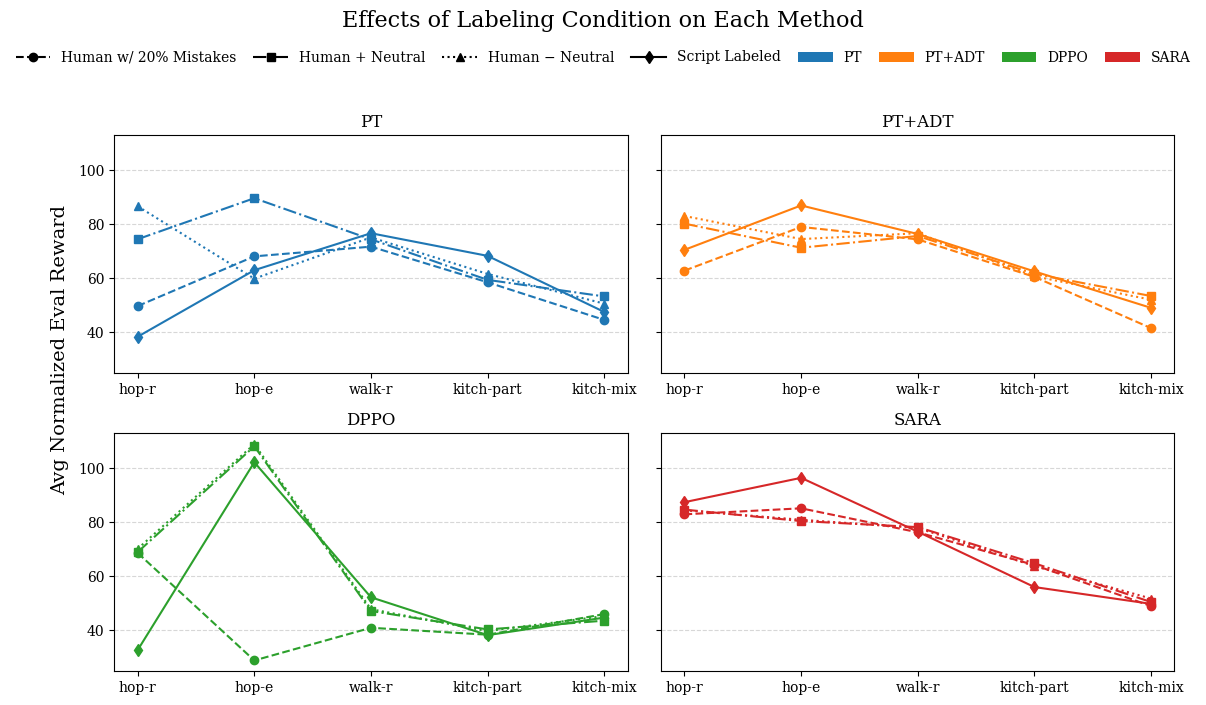

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams.update({
    "text.usetex": False,            # use mathtext, no external LaTeX
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],  # ensure a real installed serif
    "mathtext.fontset": "cm",        # Computer Modern for math
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 12,
})


# 1) Dataset (x-axis) labels, dropping walker2d-expert
tasks = ["hop-r", "hop-e", "walk-r", "kitch-part", "kitch-mix"]
x = np.arange(len(tasks))

# 2) Methods
methods = ["PT", "PT+ADT", "DPPO", "SARA"]

# 3) Labeling conditions and their styles
conds = [
    ("Human w/ 20% Mistakes", "o", "--"),
    ("Human + Neutral",       "s", "-."),
    ("Human − Neutral",       "^", ":"),
    ("Script Labeled",        "d", "-"),
]

# 4) Mean rewards for each condition (lists of length 5)
means_mistakes = {
    "PT":     [49.77,  68.14,  71.73, 58.55, 44.65],
    "PT+ADT": [62.87,  79.02,  74.42, 60.55, 41.60],
    "DPPO":   [68.67,  28.92,  41.00, 38.44, 46.05],
    "SARA":   [82.94,  85.16,  76.29, 64.18, 49.02],
}
means_with_neutral = {
    "PT":     [74.48,  89.64,  74.43, 59.45, 53.32],
    "PT+ADT": [80.24,  71.33,  75.68, 61.68, 53.48],
    "DPPO":   [68.98, 108.09,  47.21, 40.39, 43.63],
    "SARA":   [84.68,  80.45,  78.21, 64.84, 50.51],
}
means_without_neutral = {
    "PT":     [86.67,  59.90,  75.14, 61.64, 50.66],
    "PT+ADT": [83.06,  74.53,  76.69, 60.78, 52.11],
    "DPPO":   [70.18, 108.88,  47.87, 39.77, 45.35],
    "SARA":   [84.43,  80.93,  77.91, 63.79, 51.80],
}
means_script = {
    "PT":     [38.43,  63.03,  76.69, 68.32, 47.58],
    "PT+ADT": [70.55,  86.96,  76.40, 62.58, 49.10],
    "DPPO":   [32.75, 102.19,  52.27, 38.28, 44.77],
    "SARA":   [87.43,  96.43,  76.51, 56.05, 49.84],
}

data = {
    cond: means
    for cond, means in zip(
        [c[0] for c in conds],
        [means_mistakes, means_with_neutral, means_without_neutral, means_script]
    )
}

# 5) Create 2×2 panels (one per method)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()
colors = plt.get_cmap("tab10").colors

for mi, method in enumerate(methods):
    ax = axes[mi]
    for label, marker, ls in conds:
        ax.plot(
            x,
            data[label][method],
            marker=marker,
            linestyle=ls,
            color=colors[mi],
            label=label
        )
    ax.set_title(method)
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=0, ha="center")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# 6) Combine both legends (compact and low)
cond_handles = [
    Line2D([0], [0], color='k', marker=marker, linestyle=ls, label=label, markersize=6, linewidth=1.5)
    for label, marker, ls in conds
]
method_patches = [
    Patch(facecolor=colors[i], label=methods[i])
    for i in range(len(methods))
]
all_handles = cond_handles + method_patches

fig.legend(
    handles=all_handles,
    loc="upper center",
    ncol=len(all_handles),
    frameon=False,
    fontsize="medium",  # Was 'x-small'
    handlelength=2.5,
    handletextpad=0.8,
    columnspacing=1.2,
    bbox_to_anchor=(0.5, 0.89)  # Move legend closer to plots
)

fig.suptitle("Effects of Labeling Condition on Each Method", y=0.925, fontsize=16)  # Slightly lowered
plt.tight_layout(rect=[0.05, 0.05, 1, 0.86])  # Raise plot area even more

fig.text(0.04, 0.5, "Avg Normalized Eval Reward", va="center", rotation="vertical", fontsize=14)

#plt.show()
plt.savefig("/user/rajaram/u13657/rltransfer/plotvariants.pdf", format='pdf', bbox_inches='tight')


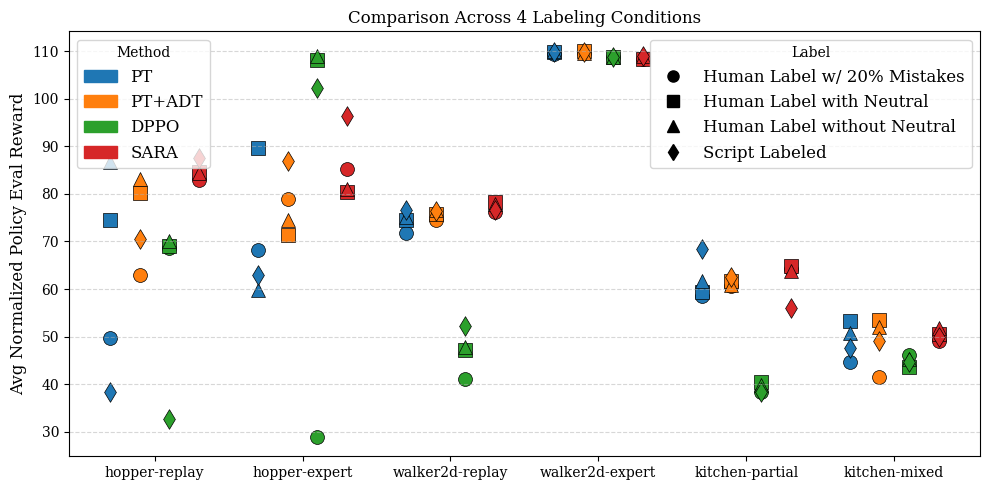

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1) Tasks
tasks_short = [
    "hopper-replay",
    "hopper-expert",
    "walker2d-replay",
    "walker2d-expert",
    "kitchen-partial",
    "kitchen-mixed"
]
x = np.arange(len(tasks_short))

# 2) Methods & colors
methods = ["PT", "PT+ADT", "DPPO", "SARA"]
colors = plt.get_cmap("tab10").colors[:len(methods)]

# 3) Marker shapes for the 4 tables
table_labels = [
    "Human Label w/ 20% Mistakes",
    "Human Label with Neutral",
    "Human Label without Neutral",
    "Script Labeled"
]
markers = ["o", "s", "^", "d"]  # one per table

# 4) Data dictionaries (means only; stds omitted in scatter)
means_mistakes = {
    "PT":     [49.77, 68.14, 71.73, 109.37, 58.55, 44.65],
    "PT+ADT": [62.87, 79.02, 74.42, 109.53, 60.55, 41.60],
    "DPPO":   [68.67, 28.92, 41.00, 108.78, 38.44, 46.05],
    "SARA":   [82.94, 85.16, 76.29, 108.37, 64.18, 49.02],
}
means_with_neutral = {
    "PT":     [74.48, 89.64, 74.43, 109.74, 59.45, 53.32],
    "PT+ADT": [80.24, 71.33, 75.68, 109.98, 61.68, 53.48],
    "DPPO":   [68.98,108.09, 47.21, 108.73, 40.39, 43.63],
    "SARA":   [84.68, 80.45, 78.21, 108.35, 64.84, 50.51],
}
means_without_neutral = {
    "PT":     [86.67, 59.90, 75.14, 110.09, 61.64, 50.66],
    "PT+ADT": [83.06, 74.53, 76.69, 109.61, 60.78, 52.11],
    "DPPO":   [70.18,108.88, 47.87, 108.77, 39.77, 45.35],
    "SARA":   [84.43, 80.93, 77.91, 108.91, 63.79, 51.80],
}
means_script = {
    "PT":     [38.43, 63.03, 76.69, 109.80, 68.32, 47.58],
    "PT+ADT": [70.55, 86.96, 76.40, 109.74, 62.58, 49.10],
    "DPPO":   [32.75,102.19, 52.27, 108.81, 38.28, 44.77],
    "SARA":   [87.43, 96.43, 76.51, 108.88, 56.05, 49.84],
}

tables = [
    means_mistakes,
    means_with_neutral,
    means_without_neutral,
    means_script,
]

# 5) Plot
fig, ax = plt.subplots(figsize=(10, 5))
n_methods = len(methods)
group_width = 0.8 / n_methods

for t_idx, (means, tbl_label) in enumerate(zip(tables, table_labels)):
    marker = markers[t_idx]
    for m_idx, method in enumerate(methods):
        # offset so methods are grouped at each x-position
        offset = (m_idx - (n_methods-1)/2) * group_width
        xpos = x + offset
        ax.scatter(
            xpos,
            means[method],
            color=colors[m_idx],
            marker=marker,
            s=100,
            edgecolor='k',
            lw=0.5
        )

# 6) Legends
# Method legend (color)
method_patches = [Patch(color=colors[i], label=methods[i]) for i in range(n_methods)]
leg1 = ax.legend(handles=method_patches, title="Method", loc="upper left")

# Table legend (marker)
table_handles = [
    Line2D([0], [0], color='k', marker=markers[i], linestyle='None', markersize=8, label=table_labels[i])
    for i in range(len(table_labels))
]
leg2 = ax.legend(handles=table_handles, title="Label", loc="upper right")
ax.add_artist(leg1)

# 7) Formatting
ax.set_xticks(x)
ax.set_xticklabels(tasks_short, rotation=0, ha="center")
ax.set_ylabel("Avg Normalized Policy Eval Reward")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_title("Comparison Across 4 Labeling Conditions")

plt.tight_layout()
plt.show()


### Human Label with Neutral vs Human Label with Error

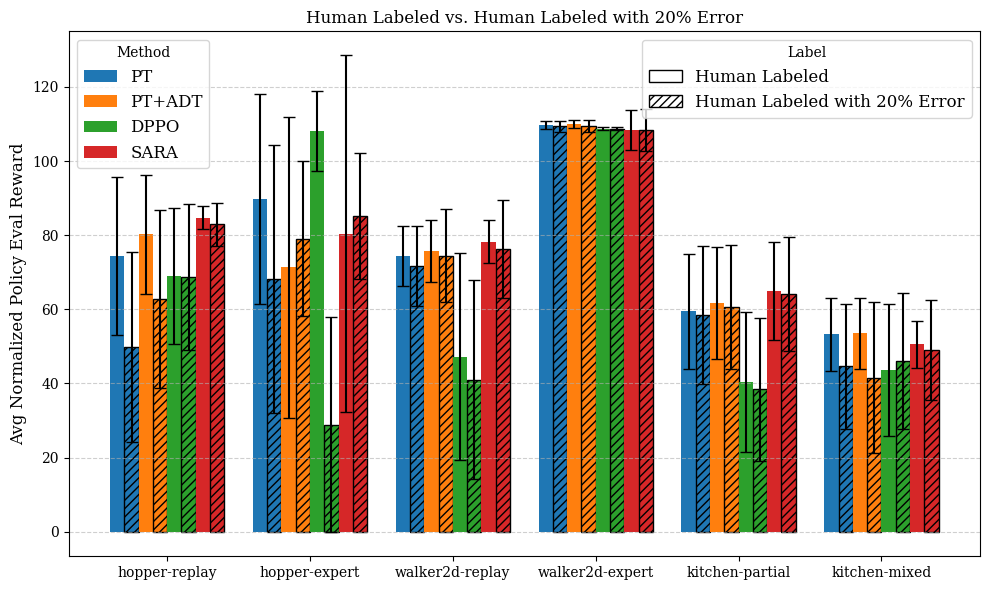

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Full task IDs (for data) and shortened labels (for x-axis)
tasks_full = [
    "hopper-medium-replay-v2",
    "hopper-medium-expert-v2",
    "walker2d-medium-replay-v2",
    "walker2d-medium-expert-v2",
    "kitchen-partial-v0",
    "kitchen-mixed-v0"
]
tasks_short = [
    "hopper-replay",
    "hopper-expert",
    "walker2d-replay",
    "walker2d-expert",
    "kitchen-partial",
    "kitchen-mixed"
]

# 2) Dataset labels (legend) and the legend title
table_labels = ["Human Labeled", "Human Labeled with 20% Error"]
legend_title = "Label"

# 3) Methods (with SR renamed to SARA) and colors
methods = ["PT", "PT+ADT", "DPPO", "SARA"]
colors = plt.get_cmap("tab10").colors[:len(methods)]

# 4) Data for Human Labeled
means_hl = {
    "PT":     [74.48, 89.64, 74.43, 109.74, 59.45, 53.32],
    "PT+ADT": [80.24, 71.33, 75.68, 109.98, 61.68, 53.48],
    "DPPO":   [68.98,108.09, 47.21, 108.73, 40.39, 43.63],
    "SARA":   [84.68, 80.45, 78.21, 108.35, 64.84, 50.51],
}
stds_hl = {
    "PT":     [21.35, 28.32,  8.04,  1.07, 15.58,  9.84],
    "PT+ADT": [16.08, 40.56,  8.33,  1.00, 15.21,  9.70],
    "DPPO":   [18.39, 10.80, 27.96,  0.43, 18.93, 17.92],
    "SARA":   [ 3.13, 48.11,  5.76,  5.38, 13.23,  6.35],
}

# 5) Data for Human Labeled with 20% Error
means_hl_err = {
    "PT":     [49.77, 68.14, 71.73, 109.37, 58.55, 44.65],
    "PT+ADT": [62.87, 79.02, 74.42, 109.53, 60.55, 41.60],
    "DPPO":   [68.67, 28.92, 41.00, 108.78, 38.44, 46.05],
    "SARA":   [82.94, 85.16, 76.29, 108.37, 64.18, 49.02],
}
stds_hl_err = {
    "PT":     [25.68, 36.23, 10.74,  1.45, 18.59, 16.90],
    "PT+ADT": [24.04, 20.95, 12.55,  1.63, 16.72, 20.49],
    "DPPO":   [19.77, 29.11, 26.84,  0.38, 19.28, 18.37],
    "SARA":   [ 5.80, 17.01, 13.20,  5.68, 15.39, 13.53],
}

# 6) Compute bar positions
x = np.arange(len(tasks_full))
n_methods = len(methods)
n_tables = 2
total_width = 0.8
bar_width = total_width / (n_methods * n_tables)

fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    center = (i - (n_methods - 1)/2) * n_tables * bar_width
    pos_hl     = x + center - bar_width/2
    pos_hl_err = x + center + bar_width/2

    # Human Labeled (solid)
    ax.bar(
        pos_hl,
        means_hl[method],
        yerr=stds_hl[method],
        width=bar_width,
        color=colors[i],
        capsize=4
    )
    # Human Labeled w/ 20% Error (hatched)
    ax.bar(
        pos_hl_err,
        means_hl_err[method],
        yerr=stds_hl_err[method],
        width=bar_width,
        color=colors[i],
        hatch='////',
        edgecolor='black',
        capsize=4
    )

# 7) Legends
method_patches = [Patch(facecolor=colors[i], label=methods[i]) for i in range(n_methods)]
leg1 = ax.legend(handles=method_patches, title="Method", loc="upper left")

table_patches = [
    Patch(facecolor="white", edgecolor="black", label=table_labels[0]),
    Patch(facecolor="white", edgecolor="black", hatch='////', label=table_labels[1])
]
leg2 = ax.legend(handles=table_patches, title=legend_title, loc="upper right")

ax.add_artist(leg1)

# 8) Final formatting (horizontal x-labels)
ax.set_xticks(x)
ax.set_xticklabels(tasks_short, rotation=0, ha="center")
ax.set_ylabel("Avg Normalized Policy Eval Reward")
ax.set_title("Human Labeled vs. Human Labeled with 20% Error")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## Check For Unfinished Runs

In [3]:
import wandb

# Initialize wandb API
api = wandb.Api()

# Parameters
tasks = ['walker2d-medium-expert-v2']#, 'hopper-medium-expert-v2',
         #'walker2d-medium-replay-v2', 'walker2d-medium-expert-v2']
mistake_rates = [0.1, 0.2, 0.4]
use05_values = [True, False]
expected_seeds = [231, 107, 93, 1, 123, 827, 67, 42]

for task in tasks:
    for mistake_rate in mistake_rates:
        for use05 in use05_values:
            # Build dataset name (mod_hopper=False, Percent=100)
            dataset_name = 'Percent100_05{}'.format(use05)
            dataset_name += '_mistake{}'.format(int(mistake_rate * 100))
            project = f"PreferenceTransformer_{task}_error"

            print(f"\nChecking project: {project}, dataset_name: {dataset_name}")
            try:
                runs = api.runs(f"{api.default_entity}/{project}")
            except wandb.errors.CommError as e:
                print(f"Failed to fetch runs for project {project}: {e}")
                continue

            # Map from seed to number of finished runs
            seed_run_count = {}
            extra_seeds = set()

            for run in runs:
                if run.state != 'finished':
                    continue
                group = run.group
                if not group.startswith(dataset_name):
                    continue
                if '_seed' not in group:
                    print(f"Warning: group name '{group}' does not contain a seed pattern")
                    continue
                try:
                    seed = int(group.split('_seed')[1].split('_')[0])
                except (IndexError, ValueError):
                    print(f"Could not parse seed from group '{group}'")
                    continue

                if seed in seed_run_count:
                    seed_run_count[seed] += 1
                else:
                    seed_run_count[seed] = 1

                if seed not in expected_seeds:
                    extra_seeds.add(seed)

            # Report issues
            missing_seeds = set(expected_seeds) - set(seed_run_count.keys())

            if missing_seeds:
                print(f"❌ Missing finished runs for seeds: {sorted(missing_seeds)}")

            duplicates = {s: c for s, c in seed_run_count.items() if c > 1}
            if duplicates:
                print(f"❌ Duplicate finished runs found for seeds: {duplicates}")

            if extra_seeds:
                print(f"❌ Extra seeds not in expected list: {sorted(extra_seeds)}")

            if not missing_seeds and not duplicates and not extra_seeds:
                print(f"✅ All good for dataset: {dataset_name} and task: {task}")



Checking project: PreferenceTransformer_walker2d-medium-expert-v2_error, dataset_name: Percent100_05True_mistake10
✅ All good for dataset: Percent100_05True_mistake10 and task: walker2d-medium-expert-v2

Checking project: PreferenceTransformer_walker2d-medium-expert-v2_error, dataset_name: Percent100_05False_mistake10
✅ All good for dataset: Percent100_05False_mistake10 and task: walker2d-medium-expert-v2

Checking project: PreferenceTransformer_walker2d-medium-expert-v2_error, dataset_name: Percent100_05True_mistake20
✅ All good for dataset: Percent100_05True_mistake20 and task: walker2d-medium-expert-v2

Checking project: PreferenceTransformer_walker2d-medium-expert-v2_error, dataset_name: Percent100_05False_mistake20
✅ All good for dataset: Percent100_05False_mistake20 and task: walker2d-medium-expert-v2

Checking project: PreferenceTransformer_walker2d-medium-expert-v2_error, dataset_name: Percent100_05True_mistake40
✅ All good for dataset: Percent100_05True_mistake40 and task: wa

In [4]:
import wandb

# Initialize wandb API
api = wandb.Api()
model_name='PreferenceTransformer'
# Parameters
tasks = ['walker2d-medium-replay-v2',] #'hopper-medium-expert-v2',
          #'walker2d-medium-replay-v2', 'walker2d-medium-expert-v2']
mistake_rates = [.1, .2, .4]#[0.1, 0.2, 0.4]
use05_values = [True, False]
expected_seeds = [231, 107, 93, 1, 123, 827, 67, 42]

for task in tasks:
    for mistake_rate in mistake_rates:
        for use05 in use05_values:
            # Construct dataset_name
            dataset_name = f'Percent100_05{use05}_mistake{int(mistake_rate * 100)}'
            group_name = f"{dataset_name}_{model_name}"
            project = f"IQL_{task}_error"

            print(f"\nChecking project: {project}, group: {group_name}")

            try:
                runs = api.runs(f"{api.default_entity}/{project}")
            except wandb.errors.CommError as e:
                print(f"Failed to fetch runs for project {project}: {e}")
                continue

            # Filter for runs in correct group with job_type is None
            matching_runs = [
                run for run in runs
                if run.group == group_name
                and run.state == "finished"
                and run.job_type is None
     
            ]

            if not matching_runs:
                print(f"❌ No finished runs found in group '{group_name}' with job_type null'")
                continue

            # Track runs by seed
            seed_run_count = {}
            extra_seeds = set()

            for run in matching_runs:
                name = run.name or ""
                found = False
                for seed in expected_seeds:
                    if f"seed{seed}" in name:
                        seed_run_count[seed] = seed_run_count.get(seed, 0) + 1
                        found = True
                        break
                if not found:
                    # Seed not in expected list, maybe it's extra or badly named
                    for token in name.split():
                        if token.startswith("seed"):
                            try:
                                val = int(token.replace("seed", ""))
                                if val not in expected_seeds:
                                    extra_seeds.add(val)
                            except ValueError:
                                pass

            # Report issues
            missing_seeds = set(expected_seeds) - set(seed_run_count.keys())
            duplicates = {s: c for s, c in seed_run_count.items() if c > 1}

            if missing_seeds:
                print(f"❌ Missing finished runs for seeds: {sorted(missing_seeds)}")

            if duplicates:
                print(f"❌ Duplicate finished runs found for seeds: {duplicates}")

            if extra_seeds:
                print(f"❌ Extra seeds not in expected list: {sorted(extra_seeds)}")

            if not missing_seeds and not duplicates and not extra_seeds:
                print(f"✅ All good for dataset: {dataset_name} and task: {task}")



Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05True_mistake10_PreferenceTransformer
❌ No finished runs found in group 'Percent100_05True_mistake10_PreferenceTransformer' with job_type null'

Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05False_mistake10_PreferenceTransformer
❌ No finished runs found in group 'Percent100_05False_mistake10_PreferenceTransformer' with job_type null'

Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05True_mistake20_PreferenceTransformer
❌ No finished runs found in group 'Percent100_05True_mistake20_PreferenceTransformer' with job_type null'

Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05False_mistake20_PreferenceTransformer
❌ Missing finished runs for seeds: [67, 123, 827]
❌ Duplicate finished runs found for seeds: {1: 2}

Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05True_mistake40_PreferenceTransformer
❌ No finished 

In [8]:
import wandb

# Initialize wandb API
api = wandb.Api()
model_name='SimilarityRewards'
# Parameters
tasks = ['hopper-medium-replay-v2', 'hopper-medium-expert-v2',
          'walker2d-medium-replay-v2', 'walker2d-medium-expert-v2']
mistake_rates = [.4]#[0.1, 0.2, 0.4]
use05_values = [True, False]
expected_seeds = [231, 107, 93, 1, 123, 827, 67, 42]

for task in tasks:
    for mistake_rate in mistake_rates:
        for use05 in use05_values:
            # Construct dataset_name
            dataset_name = f'Percent100_05{use05}_mistake{int(mistake_rate * 100)}'
            group_name = f"{dataset_name}_{model_name}"
            project = f"IQL_{task}_error"

            print(f"\nChecking project: {project}, group: {group_name}")

            try:
                runs = api.runs(f"{api.default_entity}/{project}")
            except wandb.errors.CommError as e:
                print(f"Failed to fetch runs for project {project}: {e}")
                continue

            # Filter for runs in correct group with job_type including "RandomSubseqs"
            matching_runs = [
                run for run in runs
                if run.group == group_name
                and run.state == "finished"
                and run.job_type is not None
                and "RandomSubseqs" in run.job_type
            ]

            if not matching_runs:
                print(f"❌ No finished runs found in group '{group_name}' with job_type containing 'RandomSubseqs'")
                continue

            # Track runs by seed
            seed_run_count = {}
            extra_seeds = set()

            for run in matching_runs:
                name = run.name or ""
                found = False
                for seed in expected_seeds:
                    if f"seed{seed}" in name:
                        seed_run_count[seed] = seed_run_count.get(seed, 0) + 1
                        found = True
                        break
                if not found:
                    # Seed not in expected list, maybe it's extra or badly named
                    for token in name.split():
                        if token.startswith("seed"):
                            try:
                                val = int(token.replace("seed", ""))
                                if val not in expected_seeds:
                                    extra_seeds.add(val)
                            except ValueError:
                                pass

            # Report issues
            missing_seeds = set(expected_seeds) - set(seed_run_count.keys())
            duplicates = {s: c for s, c in seed_run_count.items() if c > 1}

            if missing_seeds:
                print(f"❌ Missing finished runs for seeds: {sorted(missing_seeds)}")

            if duplicates:
                print(f"❌ Duplicate finished runs found for seeds: {duplicates}")

            if extra_seeds:
                print(f"❌ Extra seeds not in expected list: {sorted(extra_seeds)}")

            if not missing_seeds and not duplicates and not extra_seeds:
                print(f"✅ All good for dataset: {dataset_name} and task: {task}")



Checking project: IQL_hopper-medium-replay-v2_error, group: Percent100_05True_mistake40_SimilarityRewards
❌ No finished runs found in group 'Percent100_05True_mistake40_SimilarityRewards' with job_type containing 'RandomSubseqs'

Checking project: IQL_hopper-medium-replay-v2_error, group: Percent100_05False_mistake40_SimilarityRewards
❌ Missing finished runs for seeds: [123]
❌ Duplicate finished runs found for seeds: {1: 2}

Checking project: IQL_hopper-medium-expert-v2_error, group: Percent100_05True_mistake40_SimilarityRewards
❌ No finished runs found in group 'Percent100_05True_mistake40_SimilarityRewards' with job_type containing 'RandomSubseqs'

Checking project: IQL_hopper-medium-expert-v2_error, group: Percent100_05False_mistake40_SimilarityRewards
❌ Missing finished runs for seeds: [93, 107, 123, 231]
❌ Duplicate finished runs found for seeds: {1: 2}

Checking project: IQL_walker2d-medium-replay-v2_error, group: Percent100_05True_mistake40_SimilarityRewards
❌ No finished runs 

## Reward Distribution Comparisons

In [21]:
def plot_reward_dist(groundTruthRewards,prefTransRewards,simRewards,labelModifier=''):
    # Plot the histogram
    bins=100
    plt.hist(groundTruthRewards, bins=bins, label='Ground Truth', edgecolor='red',fill=False,alpha=.3)
    plt.hist(prefTransRewards, bins=bins, label='PrefTransformer {}'.format(labelModifier), edgecolor='blue',fill=False,alpha=.3)
    #plt.hist(simRewardsBad, bins=bins, label='Bad Rewards',edgecolor='green',fill=False)
    plt.hist(simRewards, bins=bins, label='SimRewards {}'.format(labelModifier),edgecolor='green',fill=False,alpha=.3)


    # Labels and title
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Rewards Histogram")

    # Show the plot
    plt.show()

In [22]:
def make_PT_dataset(env_name,seed,ckpt_dir,max_ep_len):
    dataset=make_env_and_dataset(env_name=env_name, seed=seed, ckpt_dir=ckpt_dir)
    #note that make_env_and_dataset both replaces the rewards with PT rewards from teh trained model and it inputs into the D4RLDataset class. In the init of the D4RL dataset class, a few preprocessing steps (done_floats and clip_to_eps) occur, which is the same as what we use when we make the offline dataset for our model
    #this d4rl dataset now needs to be converted to the dict dataset and normalized in accordance to what we use for the offline rl toolkit

    datasetOffline={}
    datasetOffline['observations']=dataset.observations
    datasetOffline['actions']=dataset.actions
    datasetOffline['rewards']=dataset.rewards
    datasetOffline['masks']=dataset.masks
    datasetOffline['terminals']=dataset.dones_float
    datasetOffline['next_observations']=dataset.next_observations

    datasetOffline=normalize(datasetOffline, env_name, max_episode_steps=max_ep_len)
    if 'antmaze' in env_name:
        datasetOffline['rewards'] -= 1.0
    if ('halfcheetah' in env_name or 'walker2d' in env_name or 'hopper' in env_name):
        datasetOffline['rewards'] += 0.5

    return datasetOffline

def make_offlinedataset_fromargs(cfg,reward_model):
    if reward_model=='SimilarityRewards':
        dataset=make_offline_dataset(cfg)
    elif reward_model=='PreferenceTransformer':
        dataset=make_PT_dataset(env_name=cfg['task'],seed=cfg['seed'],ckpt_dir=cfg['PrefTrans_ckpt_dir'],max_ep_len=cfg['max_ep_len'])
    else:
        raise ValueError("Reward Model must be either SimilarityRewards or PreferenceTransformer")

    return dataset

def get_PT_data(project,group,job_type,seed):
    iqlConfig=get_wandb_config(project, group, job_type, seed)
    
    dataset=make_offlinedataset_fromargs(iqlConfig,'PreferenceTransformer')
    return dataset

def return_PT_rewards(project,group,job_type,seed):
    
    dataset=get_PT_data(project,group,job_type,seed)
    prefTransRewards=dataset['rewards']
    return prefTransRewards

In [23]:
def get_wandb_config(project, group, job_type, seed):
    api = wandb.Api()

    # Fetch the run directly using filters
    runs = api.runs(f"{project}", filters={"group": group, "jobType": job_type}) #"name": run_name
    target_run=None
    for run in runs:
        if f'seed{seed}' in run.name:
            target_run=run
            break
    if target_run is None:
        raise ValueError(f"No run found with seed '{seed}' in group '{group} and jobType {job_type}'")

    # Extract config as a dictionary
    config_dict = dict(target_run.config)
    print(target_run.name)

    # Convert to YAML format (if needed)
    config_yaml = yaml.dump(config_dict, default_flow_style=False)

    return yaml.safe_load(config_yaml)  # Return as a dictionary

In [24]:

def get_sim_dataset(project,group,job_type,seed):
    iqlConfig=get_wandb_config(project, group, job_type, seed)

    dataset=make_offlinedataset_fromargs(iqlConfig,'SimilarityRewards')
    return dataset 

def get_simRewards(project,group,job_type,seed):
    dataset=get_sim_dataset(project,group,job_type,seed)
    simRewards=dataset['rewards']
    return simRewards

In [25]:
#normalize rewards and the lines in get ground truth rewards were taken from OfflineRLKit/run_examples/run_iql.py
def normalize_rewards(dataset):
    terminals_float = np.zeros_like(dataset["rewards"])
    for i in range(len(terminals_float) - 1):
        if np.linalg.norm(dataset["observations"][i + 1] -
                            dataset["next_observations"][i]
                            ) > 1e-6 or dataset["terminals"][i] == 1.0:
            terminals_float[i] = 1
        else:
            terminals_float[i] = 0

    terminals_float[-1] = 1

    # split_into_trajectories
    trajs = [[]]
    for i in range(len(dataset["observations"])):
        trajs[-1].append((dataset["observations"][i], dataset["actions"][i], dataset["rewards"][i], 1.0-dataset["terminals"][i],
                        terminals_float[i], dataset["next_observations"][i]))
        if terminals_float[i] == 1.0 and i + 1 < len(dataset["observations"]):
            trajs.append([])
    print(len(trajs))
    def compute_returns(traj):
        episode_return = 0
        for _, _, rew, _, _, _ in traj:
            episode_return += rew

        return episode_return

    trajs.sort(key=compute_returns)
    
    # normalize rewards
    dataset["rewards"] /= compute_returns(trajs[-1]) - compute_returns(trajs[0])
    dataset["rewards"] *= 1000.0

    return dataset

def get_groundtruth_data(task):
    # create env and dataset
    env = gym.make(task)
    dataset = d4rl.qlearning_dataset(env)
    if 'antmaze' in task:
        dataset["rewards"] -= 1.0
    if ("halfcheetah" in task or "walker2d" in task or "hopper" in task):
        dataset = normalize_rewards(dataset)
    return dataset

def get_ground_truth_rewards(task):
    dataset=get_groundtruth_data(task)
    return dataset['rewards']

    # env = gym.make(task)

    # env = wrappers.EpisodeMonitor(env)
    # env = wrappers.SinglePrecision(env)

    # env.seed(seed)
    # env.action_space.seed(seed)
    # env.observation_space.seed(seed)

    # dataset = D4RLDataset(env)

    # return dataset.rewards

In [26]:
## Get correlations with ground truth rewards and also quantify outlers from ground truth distribution
from scipy.stats import spearmanr, pearsonr, rankdata
def check_obs_act_aligned(modelData,gtData):
    aligned=True
    for key in ['observations','actions','next_observations']:
        if not (np.round(modelData[key],4)==np.round(gtData[key],4)).all():
            aligned=False
    return aligned

def compute_correlations_outliers(model_data,ground_truth_data):
    # first check the obs, action, next_obs are aligned (so we're computing correlations for the same input)
    if not check_obs_act_aligned(model_data,ground_truth_data):
        raise ValueError("model data not aligned with ground truth obs, act, next_obs")

    ground_truth=ground_truth_data['rewards']
    model=model_data['rewards']
    ### 1. Pearson Correlation
    pearson_corr, pValPears = pearsonr(ground_truth, model)

    ### 2. Spearman Correlation
    spearman_corr, pValSpear = spearmanr(ground_truth, model)
   

    ### 3. IQR-Based Outlier Detection (based on ground truth)
    Q1 = np.percentile(ground_truth, 25)
    Q3 = np.percentile(ground_truth, 75)
    IQR = Q3 - Q1

    # Define IQR outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Outlier detection in the model distribution
    upper_outliers = model > upper_bound
    lower_outliers = model < lower_bound

    # Count
    num_upper_outliers = np.sum(upper_outliers)
    num_lower_outliers = np.sum(lower_outliers)
    numTransitions=ground_truth.shape[0]
    return (pearson_corr,pValPears), (spearman_corr,pValSpear), num_lower_outliers/numTransitions, num_upper_outliers/numTransitions

### Get PT Rewards

In [6]:
PrefTrans_ckpt_dir='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/PrefTransformer/Percent100_05False/seed42/2025.03.15_113228' 
task='hopper-medium-replay-v2'

prefTransRewards=return_PT_rewards(task,PrefTrans_ckpt_dir)


/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 58423.35it/s]


### Similarity Rewards 

In [13]:
project='IQL_hopper-medium-replay-v2'
group='Percent100_05False_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
seed=42
simRewards=get_simRewards(project,group,job_type,seed)

seed42_2025.03.28_081608


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:07<00:00, 259.38it/s]


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 54241.05it/s]


#### Bad Run

In [7]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed93/2025.03.20_162656'#'/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed93/2025.03.01_121731'
cfg={'task':task, 'max_ep_len':max_ep_len}
if capacityEncoderFilepath is not None:
    cfg['capacityEncoderFilepath']=capacityEncoderFilepath
    cfg['causal_pool1']=False
    cfg['causal_pool2']=False
    cfg['alpha']=1.0
    cfg['beta']=0.0
    cfg['windowRewards']=None
    

cfg['seed']=93
datasetSimRewardsBad=make_offlinedataset_fromargs(cfg,'SimilarityRewards')

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 107.88it/s]


Random seed set as 93
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 22891.23it/s]


#### Good Run

In [8]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed231/2025.03.20_135527'
cfg={'task':task, 'max_ep_len':max_ep_len}
if capacityEncoderFilepath is not None:
    cfg['capacityEncoderFilepath']=capacityEncoderFilepath
    cfg['causal_pool1']=False
    cfg['causal_pool2']=False
    cfg['alpha']=1.0
    cfg['beta']=0.0
    cfg['windowRewards']=None
    

cfg['seed']=231
datasetSimRewardsGood=make_offlinedataset_fromargs(cfg,'SimilarityRewards')

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|                                                                                                                 | 0/11 [00:00<?, ?it/s]

chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 108.74it/s]


Random seed set as 231
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 23163.91it/s]


#### Good Run with Changed Weights

In [117]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed231/2025.03.20_135527'
cfg={'task':task, 'max_ep_len':max_ep_len}
if capacityEncoderFilepath is not None:
    cfg['capacityEncoderFilepath']=capacityEncoderFilepath
    cfg['causal_pool1']=False
    cfg['causal_pool2']=False
    cfg['alpha']=1.0
    cfg['beta']=-1.0
    cfg['windowRewards']=None
    

cfg['seed']=231
datasetSimRewardsGoodBneg1=make_offlinedataset_fromargs(cfg,'SimilarityRewards')
simRewardsGoodBneg1=datasetSimRewardsGoodBneg1['rewards']

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 109.21it/s]


Random seed set as 231
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 22632.02it/s]


In [114]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed231/2025.03.20_135527'
cfg={'task':task, 'max_ep_len':max_ep_len}
if capacityEncoderFilepath is not None:
    cfg['capacityEncoderFilepath']=capacityEncoderFilepath
    cfg['causal_pool1']=False
    cfg['causal_pool2']=False
    cfg['alpha']=1.0
    cfg['beta']=1.0
    cfg['windowRewards']=None
    

cfg['seed']=231
datasetSimRewardsGoodB1=make_offlinedataset_fromargs(cfg,'SimilarityRewards')
simRewardsGoodB1=datasetSimRewardsGoodB1['rewards']

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 108.71it/s]


Random seed set as 231
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 22382.88it/s]


### Ground Truth Rewards

In [9]:
sys.path.append(os.path.join(os.path.expanduser('~'),'rltransfer/PreferenceTransformer'))
from dataset_utils import D4RLDataset, reward_from_preference, reward_from_preference_transformer
import wrappers

In [10]:
seed=1
env = gym.make(task)

env = wrappers.EpisodeMonitor(env)
env = wrappers.SinglePrecision(env)

env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

datasetMethod1d4rl = D4RLDataset(env)

datasetMethod1={}
datasetMethod1['observations']=datasetMethod1d4rl.observations
datasetMethod1['actions']=datasetMethod1d4rl.actions
datasetMethod1['rewards']=datasetMethod1d4rl.rewards
datasetMethod1['masks']=datasetMethod1d4rl.masks
datasetMethod1['terminals']=datasetMethod1d4rl.dones_float
datasetMethod1['next_observations']=datasetMethod1d4rl.next_observations


/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
load datafile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.78it/s]


In [66]:
env2 = gym.make(task)
eps= 1e-5 #default taken from Preference Transformer
clip_to_eps=True #default taken from Preference Transformer
dataset = d4rl.qlearning_dataset(env2)

if clip_to_eps:
    lim = 1 - eps
    dataset['actions'] = np.clip(dataset['actions'], -lim, lim)

dones_float = np.zeros_like(dataset['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(dataset['observations'][i + 1] -
                        dataset['next_observations'][i]
                        ) > 1e-5 or dataset['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0

dones_float[-1] = 1
dataset['observations']=dataset['observations'].astype(np.float32)
dataset['actions']=dataset['actions'].astype(np.float32)
dataset['rewards']=dataset['rewards'].astype(np.float32)
dataset['masks']=1.0-dataset['terminals'].astype(np.float32)
dataset['terminals']=dones_float.astype(np.float32)
dataset['next_observations']=dataset['next_observations'].astype(
                        np.float32)
datasetMethod2=dataset

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.19it/s]


In [72]:
for key in datasetMethod2.keys():
    print(key)
    print((datasetMethod2[key]==datasetMethod1[key]).all())

observations
True
actions
True
next_observations
True
rewards
True
terminals
True
masks
True


In [11]:
groundTruthRewards=datasetMethod1['rewards']


### Rewards Comparisons

In [12]:
simRewardsBad=datasetSimRewardsBad['rewards']
simRewardsGood=datasetSimRewardsGood['rewards']

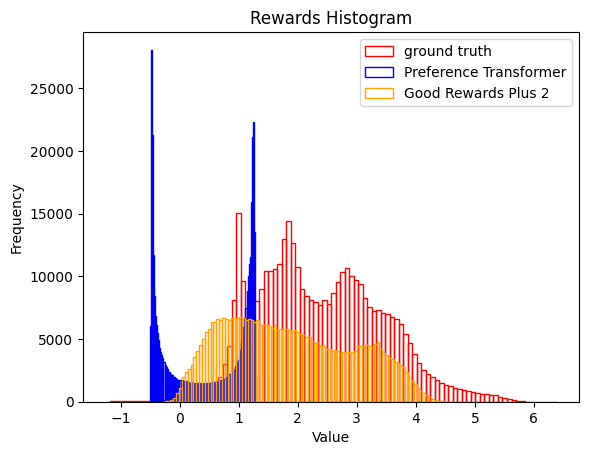

In [150]:




# Plot the histogram
bins=100
plt.hist(groundTruthRewards, bins=bins, label='ground truth', edgecolor='red',fill=False)
plt.hist(prefTransRewards, bins=bins, label='Preference Transformer', edgecolor='blue',fill=False)
#plt.hist(simRewardsBad, bins=bins, label='Bad Rewards',edgecolor='green',fill=False)
plt.hist(simRewardsGood+1.65, bins=bins, label='Good Rewards Plus 2',edgecolor='orange',fill=False)
# plt.hist(simRewardsGoodB1, bins=bins, label='Good Rewards b=1.0',edgecolor='purple',fill=False)
# plt.hist(simRewardsGoodBneg1, bins=bins, label='Good Rewards b=-1.0',edgecolor='magenta',fill=False)

# Labels and title
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Rewards Histogram")

# Show the plot
plt.show()

In [13]:
indsNeg=(groundTruthRewards<0).nonzero()[0]

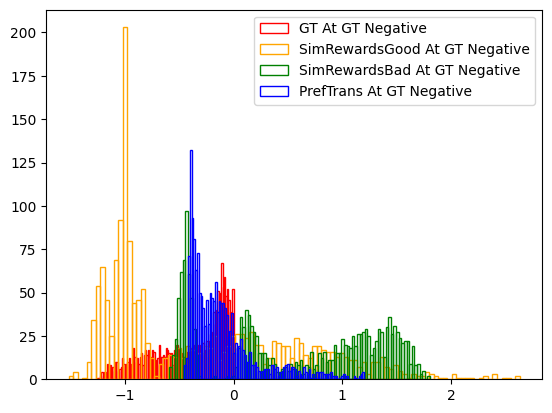

In [24]:

import matplotlib.pyplot as plt
import numpy as np
bins=100
indsNeg=(groundTruthRewards<0).nonzero()[0]
plt.hist(groundTruthRewards[indsNeg], bins=bins, label='GT At GT Negative',edgecolor='red',fill=False)
plt.hist(simRewardsGood[indsNeg], bins=bins, label='SimRewardsGood At GT Negative',edgecolor='orange',fill=False)
plt.hist(simRewardsBad[indsNeg], bins=bins, label='SimRewardsBad At GT Negative',edgecolor='green',fill=False)
plt.hist(prefTransRewards[indsNeg], bins=bins, label='PrefTrans At GT Negative',edgecolor='blue',fill=False)
plt.legend()
plt.show()

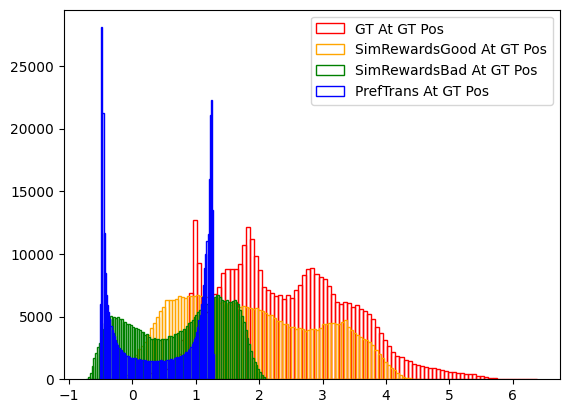

In [22]:

import matplotlib.pyplot as plt
import numpy as np
bins=100
indsPos=(groundTruthRewards>=0).nonzero()[0]
plt.hist(groundTruthRewards[indsPos], bins=bins, label='GT At GT Pos',edgecolor='red',fill=False)
plt.hist(simRewardsGood[indsPos]+1.65, bins=bins, label='SimRewardsGood At GT Pos',edgecolor='orange',fill=False)
plt.hist(simRewardsBad[indsPos], bins=bins, label='SimRewardsBad At GT Pos',edgecolor='green',fill=False)
plt.hist(prefTransRewards[indsPos], bins=bins, label='PrefTrans At GT Pos',edgecolor='blue',fill=False)
plt.legend()
plt.show()

## Examine Latents

In [44]:
import url_benchmark
from url_benchmark.pbrl.CottonDecoderV2pbrl import TransformerForInference
import torch
from torch.utils.data import DataLoader
import pickle
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import KDTree  # For nearest neighbor projection
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


### Latents Plot for Paper

In [33]:
def get_gt_rewards_prefData(preference_dataset,train_set,inputDim,device):
    obsact_pref=torch.cat([torch.tensor(preference_dataset['observations']),torch.tensor(preference_dataset['actions'])],dim=2).to(device)
    obsact_pref2=torch.cat([torch.tensor(preference_dataset['observations_2']),torch.tensor(preference_dataset['actions_2'])],dim=2).to(device)
    trajRewards=np.sum(preference_dataset['rewards'],1)
    trajRewards2=np.sum(preference_dataset['rewards_2'],1)
    env = gym.make('hopper-medium-replay-v2')
    prefTrueRew=[]
    unprefTrueRew=[]
    allRewards=[]
    for trainIdx in range(train_set.shape[0]):
        agentIdx=int(train_set[trainIdx,:,-1][0].item()) #all the same over the trajectory, so just take the first
        matches = torch.all(train_set[trainIdx,:,:inputDim] == obsact_pref, dim=(1,2))  # Shape (600,100), True where all elements match
        indices = torch.nonzero(matches, as_tuple=True)[0]  # Get indices of matches
        if len(indices)>0:
            idx=indices[0]
            totalReward=trajRewards[idx]
            

        matches2 = torch.all(train_set[trainIdx,:,:inputDim] == obsact_pref2, dim=(1,2))  # Shape (600,100), True where all elements match
        indices2 = torch.nonzero(matches2, as_tuple=True)[0]  # Get indices of matches
        if len(indices2)>0:
            idx=indices2[0]
            totalReward=trajRewards2[idx]

        normReward=env.get_normalized_score(totalReward)*100
        allRewards.append(normReward)

        if agentIdx==1:
            prefTrueRew.append(normReward)
        else:
            unprefTrueRew.append(normReward)

    allRewards=np.array(allRewards)
    return allRewards

In [51]:





# def plot_latents_GTRewards(capacityEncoderFilepath,dataset_path,device='cuda'):
#     with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
#         capEncCfg = pickle.load(f) 

#     if 'random_seqLen_start' not in capEncCfg:
#         capEncCfg['random_seqLen_start']=False
#     if 'seqLenList' not in capEncCfg:
#         capEncCfg['seqLenList']=[100]
#     capacity_inference=TransformerForInference(capEncCfg, causal_pool1=False,causal_pool2=False,window_size=None,device=device).to(device)
#     capacity_inference.eval()

#     with open(os.path.join(capacityEncoderFilepath,'train_set.pkl'), 'rb') as f:
#         train_set = pickle.load(f)

#     trainDataloader=DataLoader(train_set, batch_size=128, shuffle=False) #creating dataloader only because the relevant function (getEvalLatents) requires it as input, but will just be using the full dataset in that function. Thus the batch size we put here doesn't actually matter
#     #we get eval latents on the full training set

#     #get fixed latents from the two classes of agents (preferred and not preferred)
#     capacityEncoder=url_benchmark.pbrl.ContrastiveCapacityEncoderV2pbrl.CapacityEncoderV2(capEncCfg,train_set=train_set,test_set=[],use_wandb=False) #the train set and test set must be passed in to initialize the class but we don't use it here. 
#     capacityEncoder.capacity_encoder.load_state_dict(torch.load(os.path.join(capacityEncoderFilepath,'capacityEncoder.pt'), weights_only=True))
#     capacityEncoder.capacity_encoder.eval()
#     capacityEncoder=capacityEncoder
#     allAgentLatents={} #only used in policy eval rollouts


#     for i in range(len(capacityEncoder.agent_list)):
#         latents=capacityEncoder.getEvalLatents(i,trainDataloader).clone().detach()
#         if i==0:
#             agent='unpreferred'
#         if i==1:
#             agent='preferred'
#         allAgentLatents[agent]=latents

#     batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
#     batchMask=train_set[:,:,capacity_inference.inputDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
#     latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=False).detach() #size is batch_size, max_ep_len, embedDim
#     agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
#     latents_np = torch.mean(latents_trainset,dim=1).cpu().detach().numpy()

#     ##### Plot Latents Colored By Agent#####

#     latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
#     latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
#     # Combine the new latents with the existing ones
#     combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
#     combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

#     # Step 1: Apply t-SNE to the full set (original + new latents)
#     tsne = TSNE(n_components=2, perplexity=30, random_state=42)
#     combined_latents_2d = tsne.fit_transform(combined_latents)

#     # Extract transformed coordinates
#     latents_2d = combined_latents_2d[:-2]  # All original latents
#     latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
#     latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

#     # Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
#     plt.figure(figsize=(8, 6))
#     coolwarm = cm.get_cmap('coolwarm')

#     # Scatter plot for existing latents, colored by agent index
#     sc = plt.scatter(latents_2d[agentIndices == 0, 0], latents_2d[agentIndices == 0, 1], 
#                         color=coolwarm(1.0), marker='o', alpha=0.7, label="Non-preferred")
#     sc = plt.scatter(latents_2d[agentIndices == 1, 0], latents_2d[agentIndices == 1, 1], 
#                         color=coolwarm(0.), marker='o', alpha=0.7, label="Preferred")

#     # Highlight `latentPreferred` (star, green)
#     plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
#                 marker='*', color='lime', edgecolors='black', s=200, linewidths=1.5,
#                 label="$\mathbf{z}_p^*$")

#     # Highlight `latentUnpreferred` (triangle, red)
#     plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1],
#                 marker='^', color='cyan', edgecolors='black', s=100, linewidths=1.5, 
#                 label="$\mathbf{z}_n^*$")

#     # Colorbar and labels
#     #plt.colorbar(sc, label="Agent Index (0 or 1)")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.title("t-SNE Visualization of Encoder Latents")
#     plt.legend()
#     plt.show()
#     ######################

#     ####Plot latents with Ground Truth Rewards#####

#     with open(os.path.join(dataset_path,'preference_dataset.pkl'), 'rb') as f:
#         preference_dataset = pickle.load(f)
#     gtRewardsPrefData=get_gt_rewards_prefData(preference_dataset,train_set,inputDim=capacity_inference.inputDim,device=device)  
#     # Split indices for different marker types

#     # Create the plot
#     plt.figure(figsize=(8, 6))

#     # Plot 
#     sc0 = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
#                     c=gtRewardsPrefData, cmap='viridis', alpha=0.7)

#     # Add colorbar to show reward values
#     plt.colorbar(sc0, label="Reward Value")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.title("t-SNE Visualization of Encoder Latents")
#     plt.show()

In [86]:

def plot_latents_GTRewards(capacityEncoderFilepath, dataset_path, title_modifier, device='cuda'):
    plt.rcParams.update({
        "text.usetex": False,            # use mathtext, no external LaTeX
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],  # ensure a real installed serif
        "mathtext.fontset": "cm",        # Computer Modern for math
        "font.size": 10,
        "axes.titlesize": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 12,
    })
    with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
        capEncCfg = pickle.load(f)
    if 'random_seqLen_start' not in capEncCfg:
        capEncCfg['random_seqLen_start'] = False
    if 'seqLenList' not in capEncCfg:
        capEncCfg['seqLenList'] = [100]

    capacity_inference = TransformerForInference(
        capEncCfg, causal_pool1=False, causal_pool2=False,
        window_size=None, device=device
    ).to(device)
    capacity_inference.eval()

    with open(os.path.join(capacityEncoderFilepath,'train_set.pkl'), 'rb') as f:
        train_set = pickle.load(f)
    trainDataloader = DataLoader(train_set, batch_size=128, shuffle=False)

    capacityEncoder = url_benchmark.pbrl.ContrastiveCapacityEncoderV2pbrl.CapacityEncoderV2(
        capEncCfg, train_set=train_set, test_set=[], use_wandb=False
    )
    capacityEncoder.capacity_encoder.load_state_dict(
        torch.load(
            os.path.join(capacityEncoderFilepath,'capacityEncoder.pt'),
            weights_only=True
        )
    )
    capacityEncoder.capacity_encoder.eval()

    allAgentLatents = {}
    for i in range(len(capacityEncoder.agent_list)):
        latents = capacityEncoder.getEvalLatents(i, trainDataloader).clone().detach()
        agent = 'unpreferred' if i == 0 else 'preferred'
        allAgentLatents[agent] = latents

    batchForCapacity = train_set[:, :, :capacity_inference.inputDim]
    batchMask        = train_set[:, :, capacity_inference.inputDim]
    latents_trainset = capacity_inference.forward(
        batchForCapacity,
        src_key_padding_mask=batchMask,
        use_src_mask=False
    ).detach()
    agentIndices = np.array([
        int(i) for i in train_set[:, 0, -1].cpu().detach().numpy()
    ])
    latents_np = torch.mean(latents_trainset, dim=1).cpu().detach().numpy()

    latentUnpreferred_np = allAgentLatents['unpreferred'].cpu().detach().numpy()
    latentPreferred_np   = allAgentLatents['preferred'].cpu().detach().numpy()
    combined_latents = np.vstack([latents_np,
                                  latentPreferred_np,
                                  latentUnpreferred_np])
    _ = np.append(agentIndices, [2, 3])  # dummy so TSNE includes them

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    combined_latents_2d  = tsne.fit_transform(combined_latents)
    latents_2d           = combined_latents_2d[:-2]
    latentPreferred_2d   = combined_latents_2d[-2]
    latentUnpreferred_2d = combined_latents_2d[-1]

    with open(os.path.join(dataset_path,'preference_dataset.pkl'), 'rb') as f:
        preference_dataset = pickle.load(f)
    gtRewardsPrefData = get_gt_rewards_prefData(
        preference_dataset,
        train_set,
        inputDim=capacity_inference.inputDim,
        device=device
    )

    # --- combined figure ---
    fig = plt.figure(figsize=(12, 5))
    gs  = gridspec.GridSpec(1, 3,
                             width_ratios=[1, 1, 0.05],
                             wspace=0.1)

    # left subplot: agent-colored latents
    ax1 = fig.add_subplot(gs[0])
    cmap_cw = cm.get_cmap('coolwarm')
    ax1.scatter(
        latents_2d[agentIndices == 0, 0],
        latents_2d[agentIndices == 0, 1],
        color=cmap_cw(1.0), marker='o', alpha=0.7,
        label="Non-preferred"
    )
    ax1.scatter(
        latents_2d[agentIndices == 1, 0],
        latents_2d[agentIndices == 1, 1],
        color=cmap_cw(0.0), marker='o', alpha=0.7,
        label="Preferred"
    )
    ax1.scatter(
        latentPreferred_2d[0], latentPreferred_2d[1],
        marker='*', color='lime', edgecolors='black',
        s=200, linewidths=1.5, label=r"$\mathbf{z}_p^*$"
    )
    ax1.scatter(
        latentUnpreferred_2d[0], latentUnpreferred_2d[1],
        marker='^', color='cyan', edgecolors='black',
        s=100, linewidths=1.5, label=r"$\mathbf{z}_n^*$"
    )
    ax1.set_xlabel("t-SNE Dimension 1")
    ax1.set_ylabel("t-SNE Dimension 2")
    ax1.legend(loc='upper left')

    # middle subplot: GT rewards
    ax2 = fig.add_subplot(gs[1])
    vmin, vmax = gtRewardsPrefData.min(), gtRewardsPrefData.max()
    sc0 = ax2.scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=gtRewardsPrefData, cmap='viridis',
        vmin=vmin, vmax=vmax, alpha=0.7
    )
    ax2.set_xlabel("t-SNE Dimension 1")
    ax2.tick_params(axis='y', labelleft=False)
    # move the y-label to the right so it doesn't overlap the first plot
    # ax2.set_ylabel("t-SNE Dimension 2")
    # ax2.yaxis.set_label_position("right")
    # ax2.yaxis.tick_right()

    # right subplot: colorbar
    cax = fig.add_subplot(gs[2])
    fig.colorbar(sc0, cax=cax, label="True Task Reward Value")

    # shared title
    fig.suptitle("t-SNE Visualization of Encoder Latents: {}".format(title_modifier), fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/tmp/ipykernel_30/1661550523.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cw = cm.get_cmap('coolwarm')
/tmp/ipykernel_30/1661550523.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


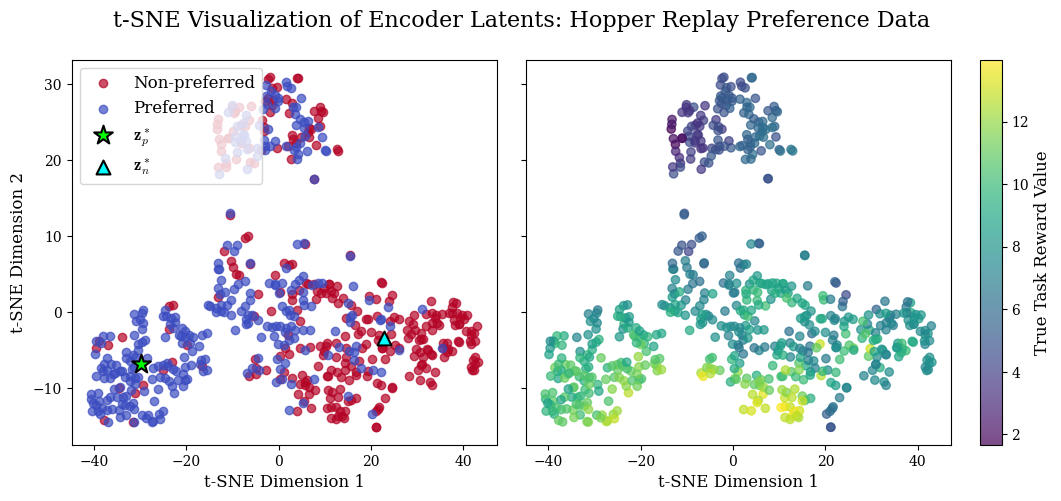

In [87]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.03.20_195727'
dataset_path='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/Data/Percent100_05False'
plot_latents_GTRewards(capacityEncoderFilepath,dataset_path,"Hopper Replay Preference Data",device='cuda')

Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


/tmp/ipykernel_30/315190656.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm = cm.get_cmap('coolwarm')


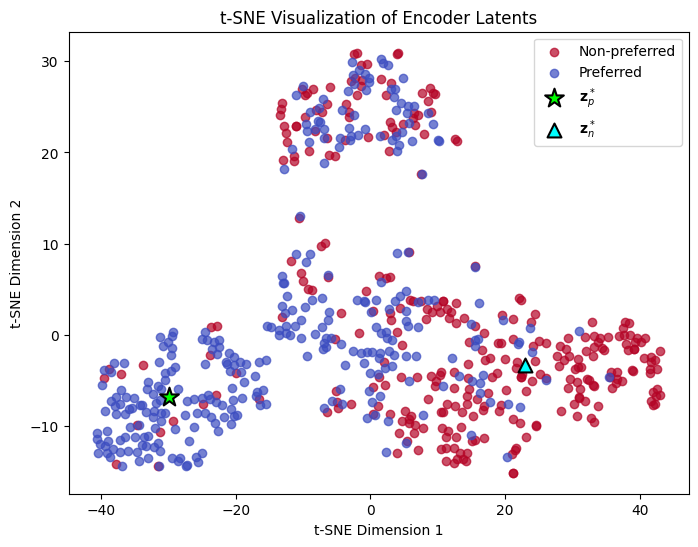

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


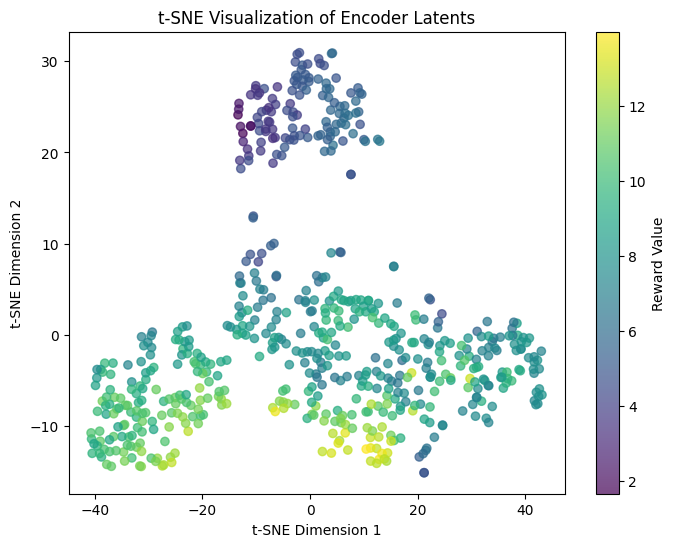

In [46]:
#capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.04.10_031001'
#capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05True/seed42/2025.03.30_090548'
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.03.20_195727'
dataset_path='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/Data/Percent100_05False'
plot_latents_GTRewards(capacityEncoderFilepath,dataset_path,device='cuda')

### Old Function to Get Latents

In [41]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.03.20_195727'
dataset_path='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/Data/Percent100_05False'
with open(os.path.join(dataset_path,'preference_dataset.pkl'), 'rb') as f:
    preference_dataset = pickle.load(f)

with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
    capEncCfg = pickle.load(f) 

capEncCfg['seqLenList']=[100]
capacity_inference=TransformerForInference(capEncCfg, causal_pool1=False,causal_pool2=False,window_size=None)
capacity_inference.eval()

with open(os.path.join(capacityEncoderFilepath,'train_set.pkl'), 'rb') as f:
    train_set = pickle.load(f)
    
train_set=train_set.to('cpu')

trainDataloader=DataLoader(train_set, batch_size=128, shuffle=False) #creating dataloader only because the relevant function (getEvalLatents) requires it as input, but will just be using the full dataset in that function. Thus the batch size we put here doesn't actually matter
#we get eval latents on the full training set

#get fixed latents from the two classes of agents (preferred and not preferred)
capacityEncoder=url_benchmark.pbrl.ContrastiveCapacityEncoderV2pbrl.CapacityEncoderV2(capEncCfg,train_set=train_set,test_set=[],use_wandb=False) #the train set and test set must be passed in to initialize the class but we don't use it here. 
capacityEncoder.capacity_encoder.load_state_dict(torch.load(os.path.join(capacityEncoderFilepath,'capacityEncoder.pt'), weights_only=True))
capacityEncoder.capacity_encoder.eval()

capacityEncoder.to('cpu')

allAgentLatents={} #only used in policy eval rollouts
for i in range(len(capacityEncoder.agent_list)):
    latentsFullAgent=capacityEncoder.getEvalLatents(i,trainDataloader).clone().detach()
    if i==0:
        agent='unpreferred'
    if i==1:
        agent='preferred'
    allAgentLatents[agent]=latentsFullAgent


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


### T-SNE Train Set Latents

#### Capacity Inference Latents: use_src_mask False, causal_pool3

In [80]:
with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
    capEncCfg = pickle.load(f) 

capEncCfg['timestep_repeat']=None
capacity_inference=TransformerForInference(capEncCfg, causal_pool1=False,causal_pool2=False,window_size=None)
capacity_inference.eval()

TransformerForInference(
  (transformer_input_layer): Linear(in_features=14, out_features=256, bias=True)
  (positional_encoding_layer): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, o

In [81]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=False).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])

cumulative_sum = torch.cumsum(latents_trainset, dim=1)  # Shape: (batch_size, max_len, d_model)
timestep_indices = torch.arange(1, latents_trainset.size(1) + 1).view(1,-1, 1)
latentsCum = cumulative_sum / timestep_indices  # Divide cumulative sums by timestep indices


(618, 16)


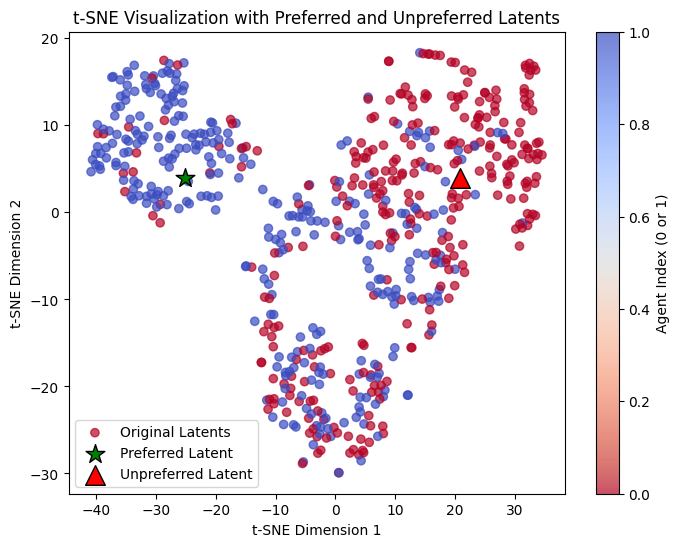

In [82]:


latents_np =latentsCum[:,-30,:].cpu().detach().numpy()#torch.mean(latents_trainset,dim=1).cpu().detach().numpy()

print(latents_np.shape)

latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

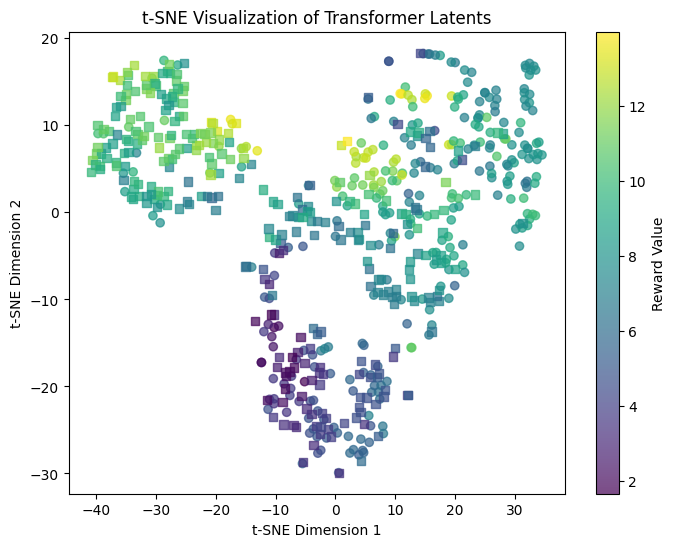

In [83]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

#### Capacity Inference Latents: use_src_mask False, causal_pool2=True

In [42]:
with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
    capEncCfg = pickle.load(f) 

capEncCfg['timestep_repeat']=None
capacity_inference=TransformerForInference(capEncCfg, causal_pool1=False,causal_pool2=True,window_size=None)
capacity_inference.eval()

TransformerForInference(
  (transformer_input_layer): Linear(in_features=14, out_features=256, bias=True)
  (positional_encoding_layer): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, o

(618, 16)


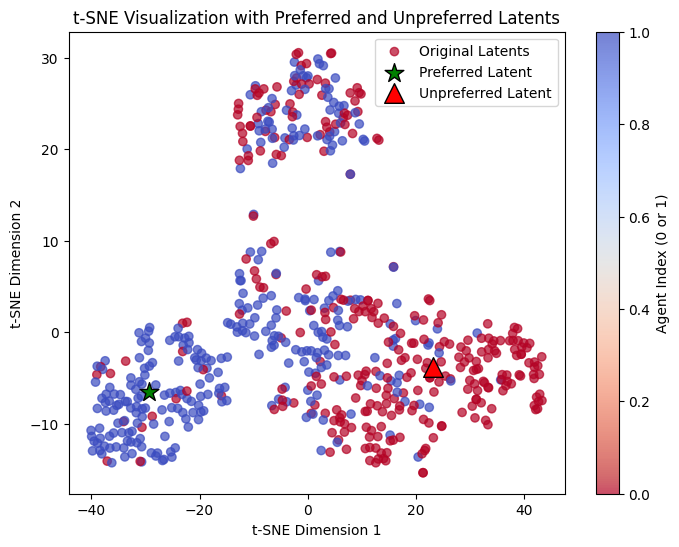

In [43]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=False).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
latents_np =latents_trainset[:,100-1,:].cpu().detach().numpy()#torch.mean(latents_trainset,dim=1).cpu().detach().numpy()

print(latents_np.shape)



latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

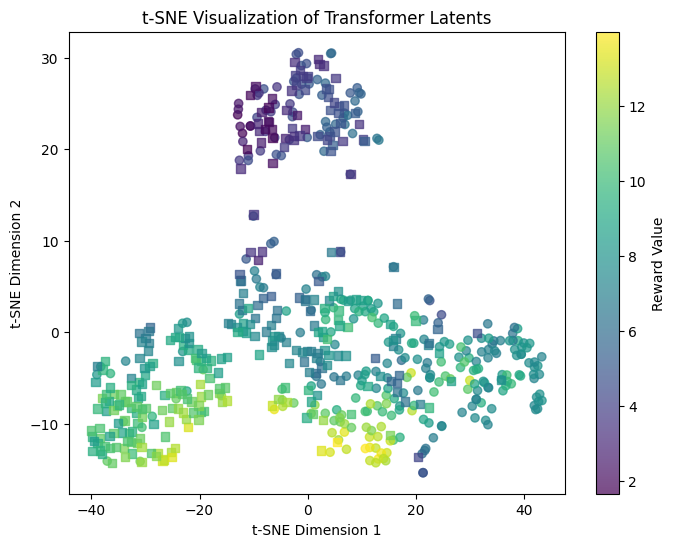

In [87]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

##### Further Analysis

##### How does similarity with the eval latent vary with this chart?

In [90]:
cos=torch.nn.CosineSimilarity(dim=2)
max_ep_len=100
simWUnpreferred=cos(latents_trainset,allAgentLatents['unpreferred'].repeat(max_ep_len,1)) #
simWPreferred=cos(latents_trainset,allAgentLatents['preferred'].repeat(max_ep_len,1)) 

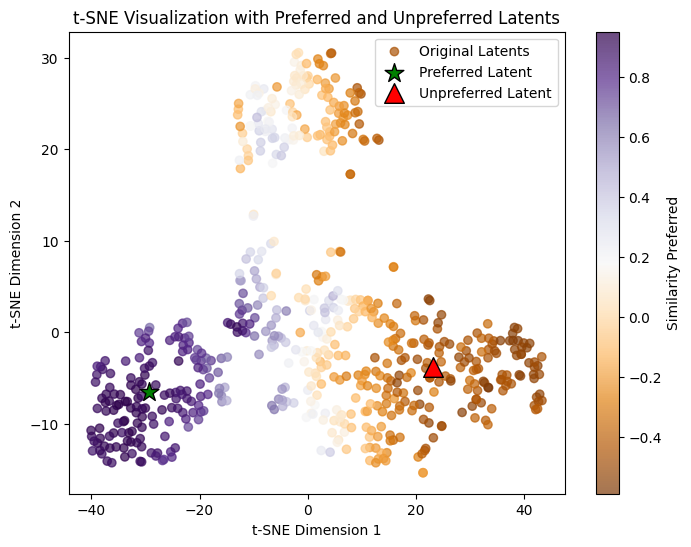

In [96]:
simPref=simWPreferred[:,-1]
simUnpref=simWUnpreferred[:,-1]



latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=simPref, cmap='PuOr', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Similarity Preferred")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

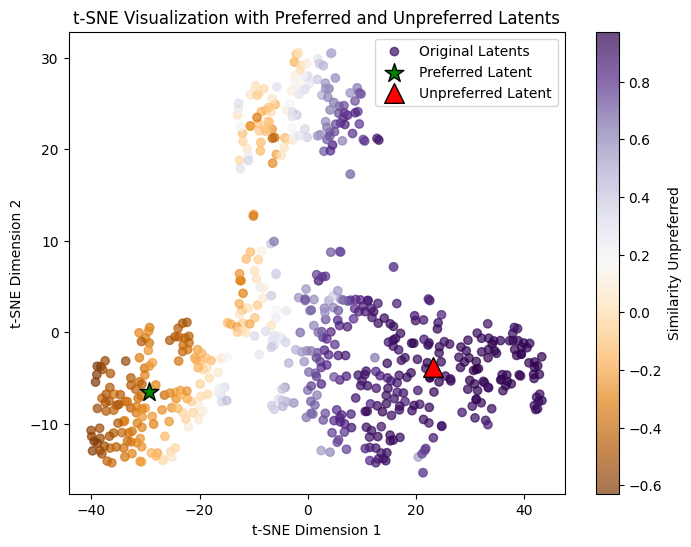

In [98]:
simPref=simWPreferred[:,-1]
simUnpref=simWUnpreferred[:,-1]



latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=simUnpref, cmap='PuOr', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Similarity Unpreferred")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

In [ ]:
mostSimilarToGood=simPref.argmax().item()
print(agentIndices[mostSimilarToGood])
print(allRewards[mostSimilarToGood])

print("###########")
mostDissimilarToBad=simUnpref.argmin().item()
print(agentIndices[mostDissimilarToBad])
print(allRewards[mostDissimilarToBad])

print("##########")
highestReward=allRewards.argmax()
print(agentIndices[highestReward])
print(allRewards[highestReward])
print(simPref[highestReward])
print(simUnpref[highestReward])

In [137]:
np.round(simUnpref[highestReward].numpy(),2)

0.83

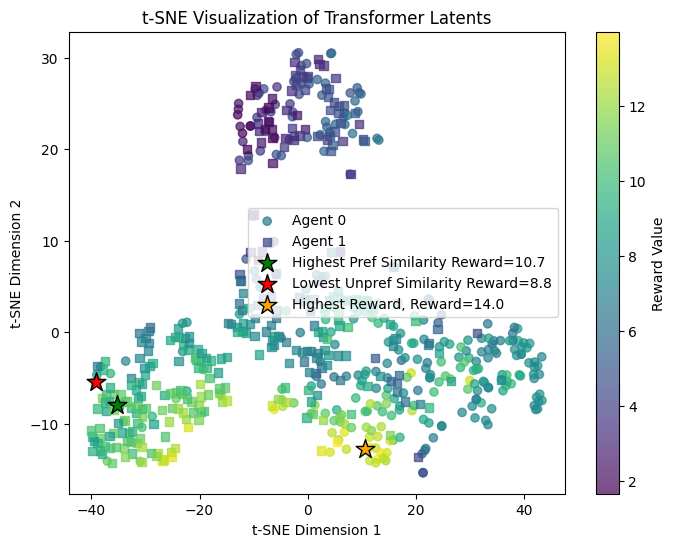

In [146]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")


plt.scatter(latents_2d[mostSimilarToGood, 0], latents_2d[mostSimilarToGood, 1], 
            color='green', edgecolors='black', marker='*', s=200, label="Highest Pref Similarity Reward={}".format(np.round(allRewards[mostSimilarToGood],1)))
plt.scatter(latents_2d[mostDissimilarToBad, 0], latents_2d[mostDissimilarToBad, 1], 
            color='red', edgecolors='black', marker='*', s=200, label="Lowest Unpref Similarity Reward={}".format(np.round(allRewards[mostDissimilarToBad],1)))
plt.scatter(latents_2d[highestReward, 0], latents_2d[highestReward, 1], 
            color='orange', edgecolors='black', marker='*', s=200, label="Highest Reward, Reward={}".format(np.round(allRewards[highestReward],1)))

# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.legend()
plt.show()

In [150]:
secondEncoder=capacityEncoder.capacity_encoder.secondEncoder

In [154]:
## get the preferred training set that 
i=0
allIndsAgenti=(train_set[:,0,-1]==i).nonzero().flatten()
uniqueTrajs_i=torch.unique(train_set[allIndsAgenti],dim=0)
batch=uniqueTrajs_i[:,:,:-1]
setSize=uniqueTrajs_i[:,:,:-1].shape[0]
numSetsPerAgent=1
eval=True
batchData=batch[:,:,:obsDim+actionDim]
mask=batch[:,:,obsDim+actionDim].to(torch.bool)
src_key_padding_mask=mask

out = capacityEncoder.capacity_encoder.transformer_input_layer(batchData)
out = capacityEncoder.capacity_encoder.positional_encoding_layer(out)
        
src_mask=None
        
out=capacityEncoder.capacity_encoder.encoder(src=out,mask=src_mask,src_key_padding_mask=src_key_padding_mask.bool())
tokenOut=torch.mean(out,dim=1)
inputForSecondLayer=tokenOut.unsqueeze(0) #in eval mode, pass everything we have for this agent in. This will be the embeddings for multiple trajectories, but all pertaining to the same agent

                


In [161]:
# Dictionary to store attention weights
attention_weights = {}

# Hook function to capture attention weights
def get_attention_weights(layer_name):
    def hook(module, input, output):
        if isinstance(output, tuple) and len(output) > 1:
            attn_weights = output[1]  # Extract attention weights
            if attn_weights is not None:
                attention_weights[layer_name] = attn_weights.detach()
                print(f"Captured attention weights for {layer_name}: {attn_weights.shape}")
            else:
                print(f"Warning: No attention weights for {layer_name}")
        else:
            print(f"Warning: Unexpected output format from {layer_name}")
    return hook

# Register hooks on all Transformer encoder layers
for i, layer in enumerate(secondEncoder.layers):
    layer.self_attn.register_forward_hook(get_attention_weights(f"layer_{i}"))
    print(f"Hook registered for layer_{i}")



# Forward pass to collect attention weights
with torch.no_grad():
    _ = secondEncoder(inputForSecondLayer)

# Verify stored attention weights
print("\nStored attention layers:", attention_weights.keys())

# Access and print the shape of attention weights for layer_0
if 'layer_0' in attention_weights:
    print("\nAttention weights shape (batch, heads, seq_len, seq_len):", attention_weights['layer_0'].shape)
else:
    print("\nLayer_0 attention weights were not captured.")

Hook registered for layer_0


AttributeError: 'NoneType' object has no attribute 'detach'

#### Capacity Inference Latents: use_src_mask False and last timestep

In [26]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=False).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
latents_np = latents_trainset[:,-1,:].cpu().detach().numpy()
print(latents_np.shape)

(618, 16)


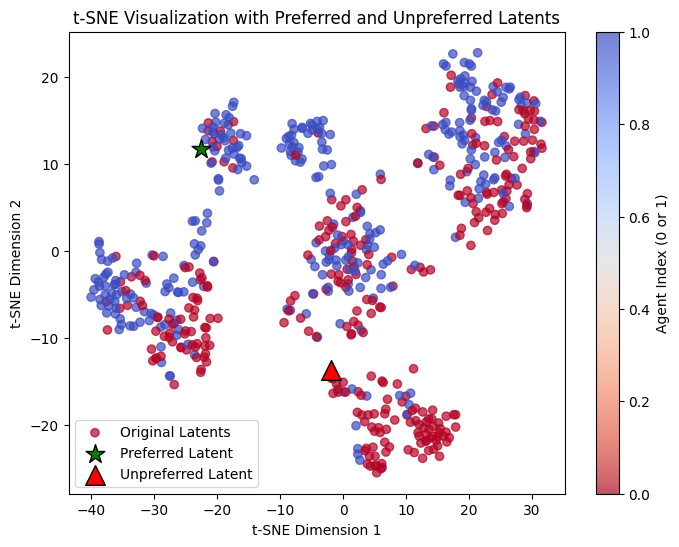

In [27]:
latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

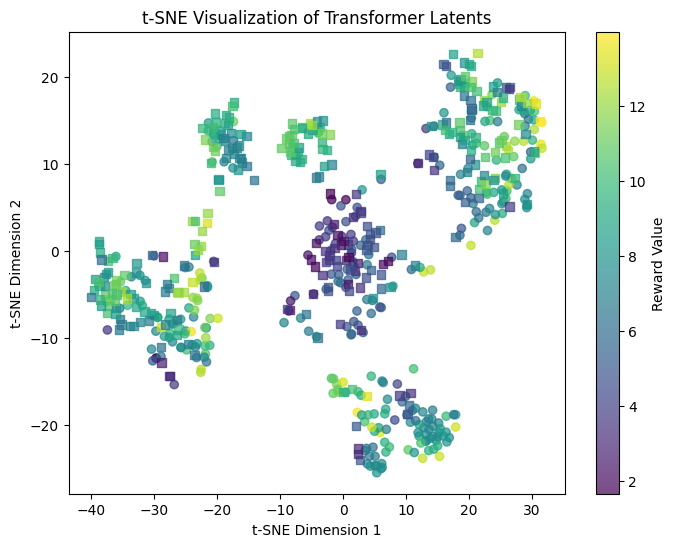

In [28]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

#### Capacity Inference Latents: use_src_mask False and mean timestep

In [8]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=False).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
latents_np = torch.mean(latents_trainset,dim=1).cpu().detach().numpy()
print(latents_np.shape)

(618, 16)


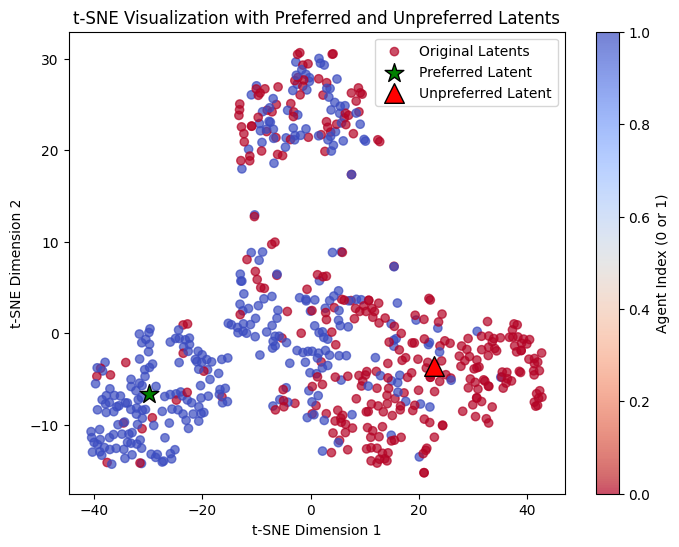

In [11]:
latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

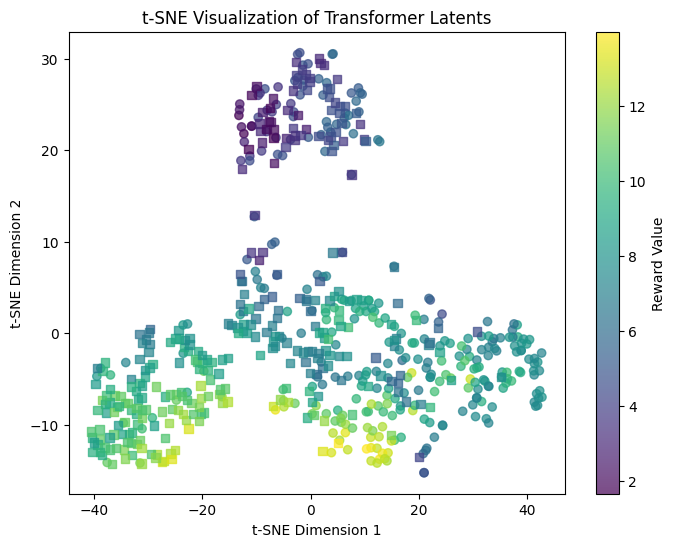

In [23]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

#### Capacity Inference Latents: last timestep

In [26]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
latents_np = latents_trainset[:,-1,:].cpu().detach().numpy()
print(latents_np.shape)

(618, 16)


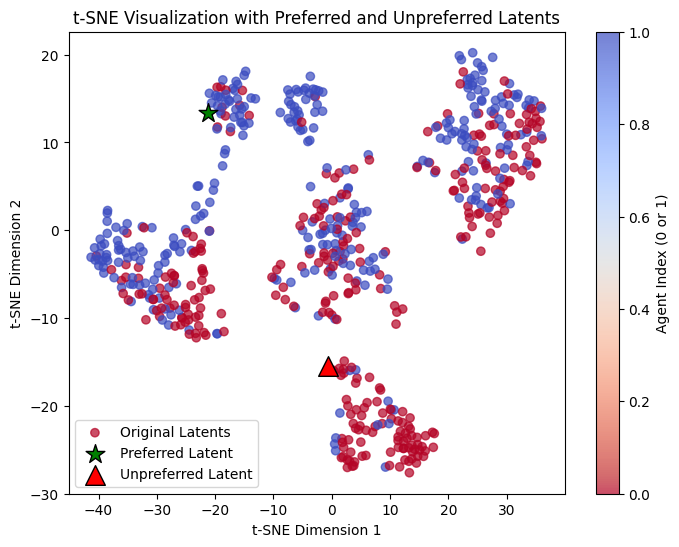

In [27]:
latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

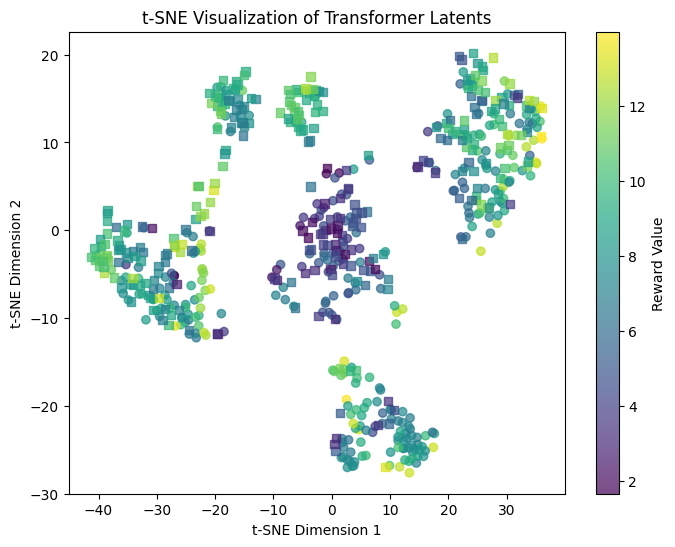

In [28]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

#### Capacity_inference latents: mean over timesteps with src_mask

In [16]:
obsDim=11
actionDim=3
batchForCapacity=train_set[:,:,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
batchMask=train_set[:,:,obsDim+actionDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask).detach() #size is batch_size, max_ep_len, embedDim
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])

In [17]:
latents_np = torch.mean(latents_trainset,dim=1).cpu().detach().numpy()
print(latents_np.shape)


(618, 16)


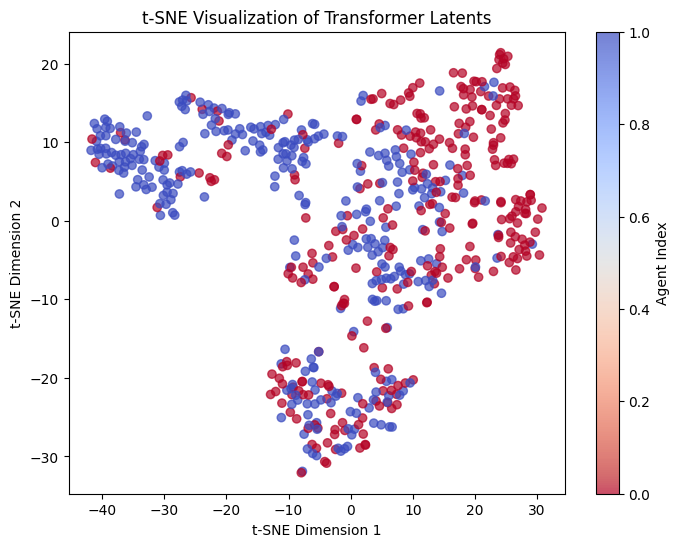

In [19]:
# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(latents_np)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
sc=plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7)

plt.colorbar(sc, label="Agent Index")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

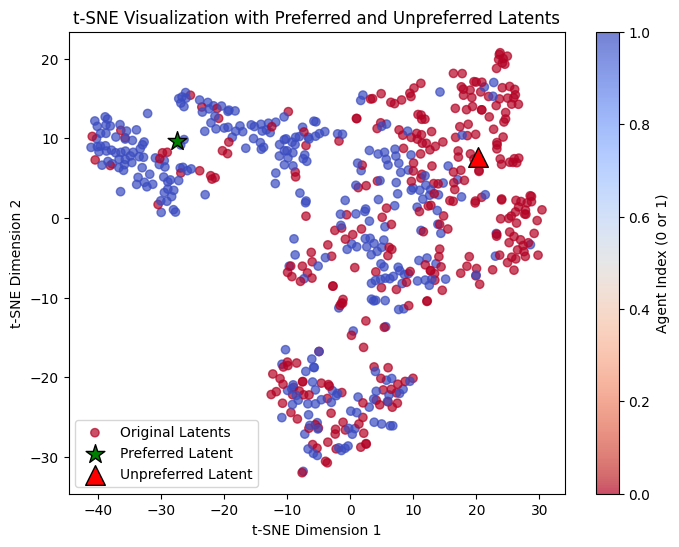

In [25]:
latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

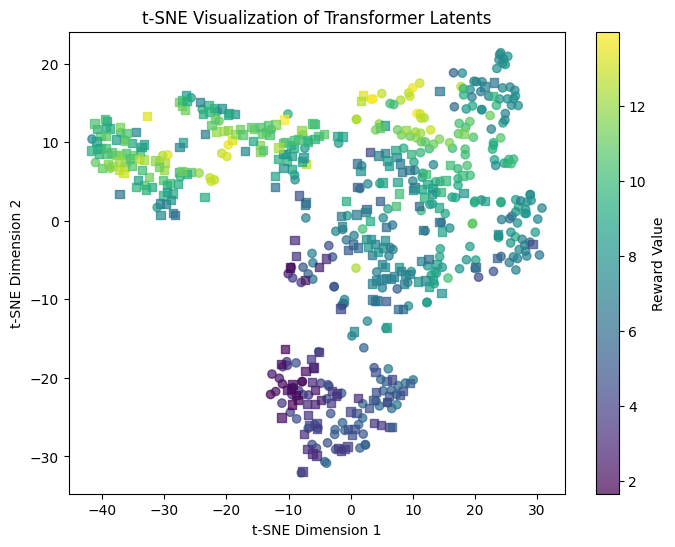

In [23]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

#### With CapacityEncoder Latents

In [117]:
agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])


In [94]:
capacityEncoder=capacityEncoder.to('cpu')
latents_trainset_capenc1=capacityEncoder.forward(train_set[:,:,:-1], setSize=None, numSetsPerAgent=None, eval=None)
latents_trainset_capenc1.shape

torch.Size([618, 16])

In [22]:
allRewards=np.array(allRewards)

In [142]:
latentPreferred.shape

(2,)

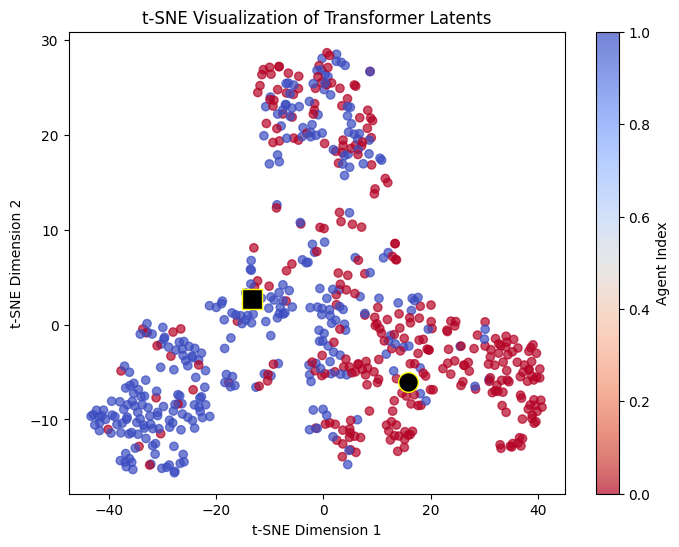

In [149]:
latents_np = latents_trainset_capenc1.cpu().detach().numpy()
# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(latents_np)

# Split indices for different marker types
indices_0 = agentIndices == 0  # Mask for agent 0
indices_1 = agentIndices == 1  # Mask for agent 1

# Create the plot
plt.figure(figsize=(8, 6))

# # Plot agent 0 (Circles)
# sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
#                   c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# # Plot agent 1 (Squares)
# sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
#                   c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")

# Project `latentNew` into t-SNE space using nearest neighbor interpolation
kdtree = KDTree(latents_np)  # Build KDTree on original latents
_, nearest_idx = kdtree.query(allAgentLatents['preferred'].squeeze())  # Find nearest neighbor index
latentPreferred = latents_2d[nearest_idx]  # Assign it the same t-SNE coordinate

_, nearest_idx = kdtree.query(allAgentLatents['unpreferred'].squeeze())  # Find nearest neighbor index
latentUnpreferred = latents_2d[nearest_idx]  # Assign it the same t-SNE coordinate

# Plot with color based on agentIndices (0 → one color, 1 → another color)
sc0 = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7)

# Highlight the new latent in black
plt.scatter(latentPreferred[0], latentPreferred[1], 
            color='black', edgecolors='Yellow', marker='s', s=200, label="Preferred Latent")

# Highlight the new latent in black
plt.scatter(latentUnpreferred[0], latentUnpreferred[1], 
            color='black', edgecolors='Yellow', marker='o', s=200, label="Unpreferred Latent")



# Add colorbar to show reward values
plt.colorbar(sc0, label="Agent Index")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

In [143]:
allAgentLatents['unpreferred']

tensor([[ 1.0972e-01, -2.3268e-05, -3.2481e-01, -3.4108e-01, -2.9529e-01,
          1.7976e-01, -4.3554e-01, -1.6357e-01, -3.5085e-02, -2.3074e-01,
         -3.2227e-01,  2.8004e-01, -4.0875e-02, -2.6024e-01, -2.8283e-01,
          4.6699e-01]])

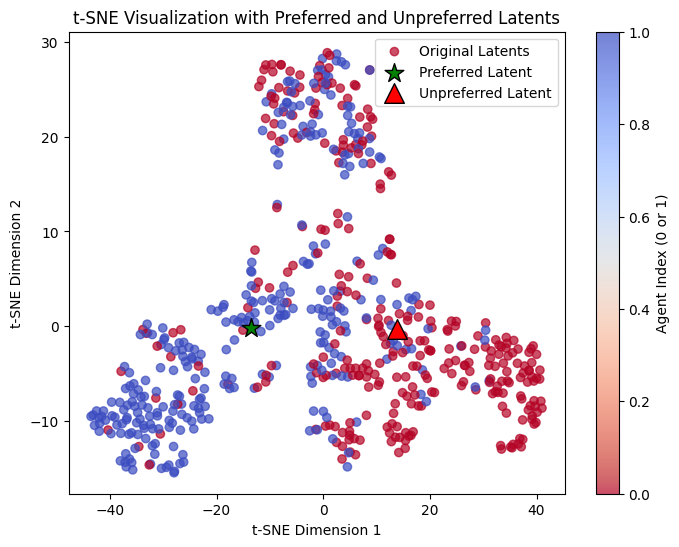

In [150]:
latentUnpreferred_np=allAgentLatents['unpreferred'].cpu().detach().numpy()
latentPreferred_np=allAgentLatents['preferred'].cpu().detach().numpy()
# Combine the new latents with the existing ones
combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

# Step 1: Apply t-SNE to the full set (original + new latents)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_latents_2d = tsne.fit_transform(combined_latents)

# Extract transformed coordinates
latents_2d = combined_latents_2d[:-2]  # All original latents
latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

# Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
plt.figure(figsize=(8, 6))

# Scatter plot for existing latents, colored by agent index
sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                 c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

# Highlight `latentPreferred` (star, green)
plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
            color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

# Highlight `latentUnpreferred` (triangle, red)
plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
            color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

# Colorbar and labels
plt.colorbar(sc, label="Agent Index (0 or 1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization with Preferred and Unpreferred Latents")
plt.legend()
plt.show()

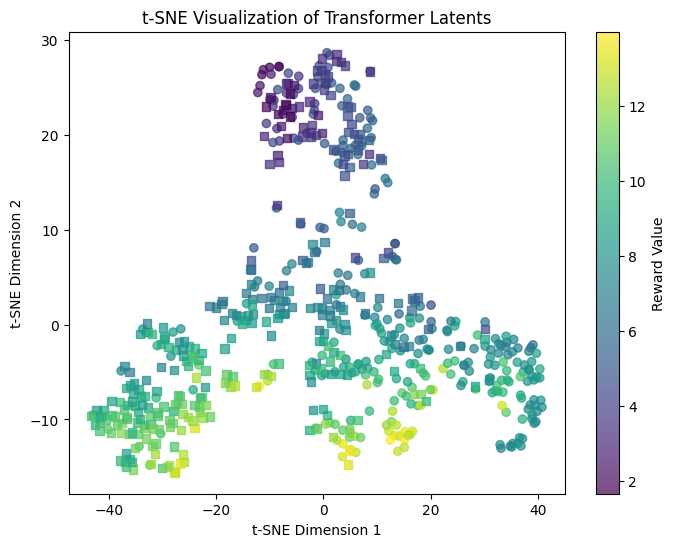

In [123]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot agent 0 (Circles)
sc0 = plt.scatter(latents_2d[indices_0, 0], latents_2d[indices_0, 1], 
                  c=allRewards[indices_0], cmap='viridis', marker='o', alpha=0.7, label="Agent 0")

# Plot agent 1 (Squares)
sc1 = plt.scatter(latents_2d[indices_1, 0], latents_2d[indices_1, 1], 
                  c=allRewards[indices_1], cmap='viridis', marker='s', alpha=0.7, label="Agent 1")




# Add colorbar to show reward values
plt.colorbar(sc0, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Transformer Latents")
plt.show()

### Visualize True Rewards

In [22]:

obsact_pref=torch.cat([torch.tensor(preference_dataset['observations']),torch.tensor(preference_dataset['actions'])],dim=2)
obsact_pref2=torch.cat([torch.tensor(preference_dataset['observations_2']),torch.tensor(preference_dataset['actions_2'])],dim=2)
trajRewards=np.sum(preference_dataset['rewards'],1)
trajRewards2=np.sum(preference_dataset['rewards_2'],1)
env = gym.make('hopper-medium-replay-v2')
prefTrueRew=[]
unprefTrueRew=[]
allRewards=[]
for trainIdx in range(train_set.shape[0]):
    agentIdx=int(train_set[trainIdx,:,-1][0].item()) #all the same over the trajectory, so just take the first
    matches = torch.all(train_set[trainIdx,:,:14] == obsact_pref, dim=(1,2))  # Shape (600,100), True where all elements match
    indices = torch.nonzero(matches, as_tuple=True)[0]  # Get indices of matches
    if len(indices)>0:
        idx=indices[0]
        totalReward=trajRewards[idx]
        

    matches2 = torch.all(train_set[trainIdx,:,:14] == obsact_pref2, dim=(1,2))  # Shape (600,100), True where all elements match
    indices2 = torch.nonzero(matches2, as_tuple=True)[0]  # Get indices of matches
    if len(indices2)>0:
        idx=indices2[0]
        totalReward=trajRewards2[idx]

    normReward=env.get_normalized_score(totalReward)*100
    allRewards.append(normReward)

    if agentIdx==1:
        prefTrueRew.append(normReward)
    else:
        unprefTrueRew.append(normReward)

allRewards=np.array(allRewards)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


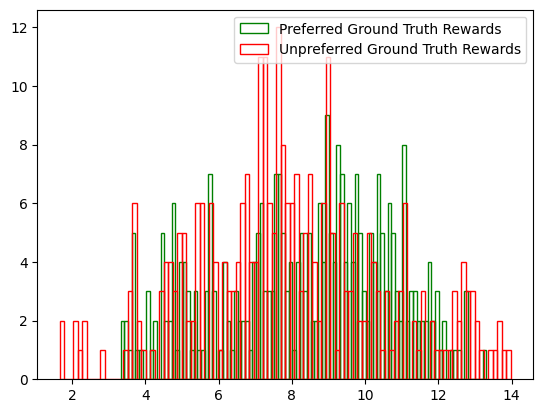

In [97]:


bins=100

plt.hist(prefTrueRew, bins=bins, label='Preferred Ground Truth Rewards',edgecolor='green',fill=False)
plt.hist(unprefTrueRew, bins=bins, label='Unpreferred Ground Truth Rewards',edgecolor='red',fill=False)
plt.legend()
plt.show()

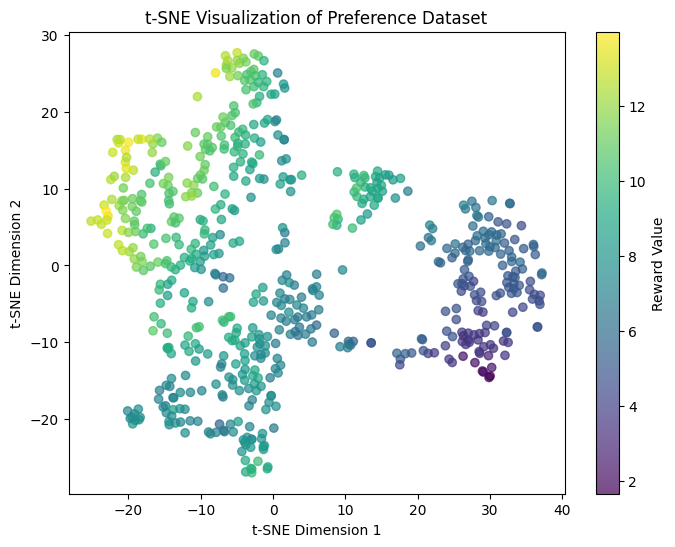

In [106]:
trainset_trajmean=torch.mean(train_set[:,:,:14],dim=1).cpu().detach().numpy()
# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
trainset_trajmean_2d = tsne.fit_transform(trainset_trajmean)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
sc=plt.scatter(trainset_trajmean_2d[:, 0], trainset_trajmean_2d[:, 1], alpha=0.7, c=allRewards, cmap='viridis')

# Add colorbar to show reward values
plt.colorbar(sc, label="Reward Value")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Preference Dataset")
plt.show()

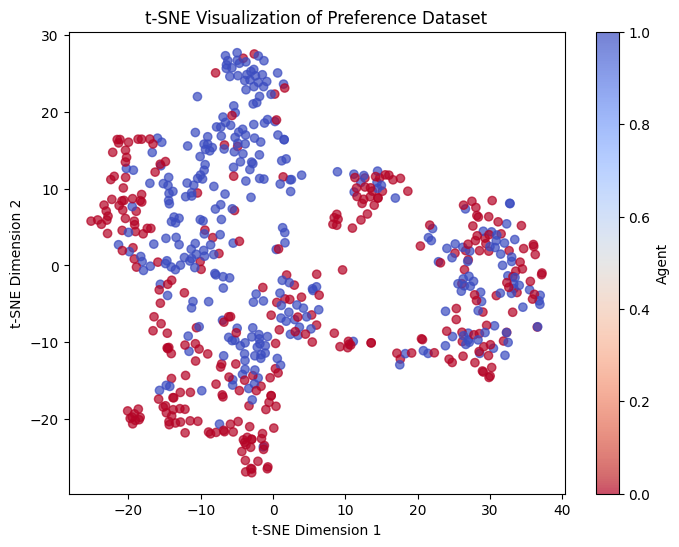

In [148]:
# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
sc=plt.scatter(trainset_trajmean_2d[:, 0], trainset_trajmean_2d[:, 1], alpha=0.7, c=agentIndices, cmap='coolwarm_r', marker='o')

# Add colorbar to show reward values
plt.colorbar(sc, label="Agent")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Preference Dataset")
plt.show()

## Examine Latents With Varying Seq Length Training

In [3]:

import url_benchmark
from url_benchmark.pbrl.CottonDecoderV2pbrl import TransformerForInference
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.device_count())  # Should return 1, only GPU 0 is visible
print(torch.cuda.current_device())  # Should return 0
print(torch.cuda.get_device_name(0))  # Should return the name of GPU 0

from torch.utils.data import DataLoader
import pickle
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import KDTree  # For nearest neighbor projection
import matplotlib.pyplot as plt
import numpy as np

1
0
NVIDIA A100-SXM4-80GB MIG 2g.20gb


In [18]:
def get_models_and_latents(capacityEncoderFilepath,causal_pool2=True,window_size=None,seqLenList=None):


    with open(os.path.join(capacityEncoderFilepath,'cfg.pkl'), 'rb') as f:
        capEncCfg = pickle.load(f) 

    capEncCfg['device']='cpu'
    capacity_inference=TransformerForInference(capEncCfg, causal_pool1=False,causal_pool2=causal_pool2,window_size=window_size) #Causal pool2 set to True
    capacity_inference.eval()

    with open(os.path.join(capacityEncoderFilepath,'train_set.pkl'), 'rb') as f:
        train_set = pickle.load(f)
        
    train_set=train_set.to('cpu')

    trainDataloader=DataLoader(train_set, batch_size=128, shuffle=False) #creating dataloader only because the relevant function (getEvalLatents) requires it as input, but will just be using the full dataset in that function. Thus the batch size we put here doesn't actually matter
    #we get eval latents on the full training set

    #get fixed latents from the two classes of agents (preferred and not preferred)
    capacityEncoder=url_benchmark.pbrl.ContrastiveCapacityEncoderV2pbrl.CapacityEncoderV2(capEncCfg,train_set=train_set,test_set=[],use_wandb=False) #the train set and test set must be passed in to initialize the class but we don't use it here. 
    capacityEncoder.capacity_encoder.load_state_dict(torch.load(os.path.join(capacityEncoderFilepath,'capacityEncoder.pt'), weights_only=True))
    capacityEncoder.capacity_encoder.eval()

    capacityEncoder.to('cpu')

    allAgentLatents={} #only used in policy eval rollouts
    if seqLenList is None:
        seqLenList=capEncCfg['seqLenList']
    for seqLen in seqLenList:
        allAgentLatents['seqLen{}'.format(seqLen)]={}
        for i in range(len(capacityEncoder.agent_list)):
            latentsFullAgent=capacityEncoder.getEvalLatents(i,trainDataloader,seqLen=seqLen).clone().detach()
            if i==0:
                agent='unpreferred'
            if i==1:
                agent='preferred'
            allAgentLatents['seqLen{}'.format(seqLen)][agent]=latentsFullAgent
    return capacity_inference, train_set, allAgentLatents

In [36]:


def show_tsne_withlatents(capacity_inference, seqLen, train_set,use_src_mask=False):

    batchForCapacity=train_set[:,:seqLen,:capacity_inference.inputDim] #needed for the capacity latent inference, not distinguishing by agent type
    batchMask=train_set[:,:seqLen,capacity_inference.inputDim] #padding mask, needed for both the decoder loss and the capacity latent inference 
    latents_trainset=capacity_inference.forward(batchForCapacity, src_key_padding_mask=batchMask, use_src_mask=use_src_mask).detach() #size is batch_size, max_ep_len, embedDim
    agentIndices=np.array([int(i) for i in train_set[:,0,-1].cpu().detach().numpy()])
    latents_np =latents_trainset[:,-1,:].cpu().detach().numpy()#torch.mean(latents_trainset,dim=1).cpu().detach().numpy()##

    print(latents_np.shape)



    latentUnpreferred_np=allAgentLatents['seqLen{}'.format(seqLen)]['unpreferred'].cpu().detach().numpy()
    latentPreferred_np=allAgentLatents['seqLen{}'.format(seqLen)]['preferred'].cpu().detach().numpy()
    # Combine the new latents with the existing ones
    combined_latents = np.vstack([latents_np, latentPreferred_np, latentUnpreferred_np])
    combined_agent_indices = np.append(agentIndices, [2, 3])  # Assign different labels for new latents

    # Step 1: Apply t-SNE to the full set (original + new latents)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    combined_latents_2d = tsne.fit_transform(combined_latents)

    # Extract transformed coordinates
    latents_2d = combined_latents_2d[:-2]  # All original latents
    latentPreferred_2d = combined_latents_2d[-2]  # Preferred latent
    latentUnpreferred_2d = combined_latents_2d[-1]  # Unpreferred latent

    # Step 2: Plot t-SNE with `latentPreferred` and `latentUnpreferred` marked differently
    plt.figure(figsize=(8, 6))

    # Scatter plot for existing latents, colored by agent index
    sc = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                    c=agentIndices, cmap='coolwarm_r', marker='o', alpha=0.7, label="Original Latents")

    # Highlight `latentPreferred` (star, green)
    plt.scatter(latentPreferred_2d[0], latentPreferred_2d[1], 
                color='green', edgecolors='black', marker='*', s=200, label="Preferred Latent")

    # Highlight `latentUnpreferred` (triangle, red)
    plt.scatter(latentUnpreferred_2d[0], latentUnpreferred_2d[1], 
                color='red', edgecolors='black', marker='^', s=200, label="Unpreferred Latent")

    # Colorbar and labels
    plt.colorbar(sc, label="Agent Index (0 or 1)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization for SeqLen {}".format(seqLen))
    plt.legend()
    plt.show()

### Use src_mask=False and causal_pool2=True, seqLenList=[10,30,50,80,10]

In [19]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.03.26_143616'

capacity_inference, train_set, allAgentLatents=get_models_and_latents(capacityEncoderFilepath)

Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


In [20]:
allAgentLatents.keys()

dict_keys(['seqLen10', 'seqLen30', 'seqLen50', 'seqLen80', 'seqLen100'])

(618, 16)


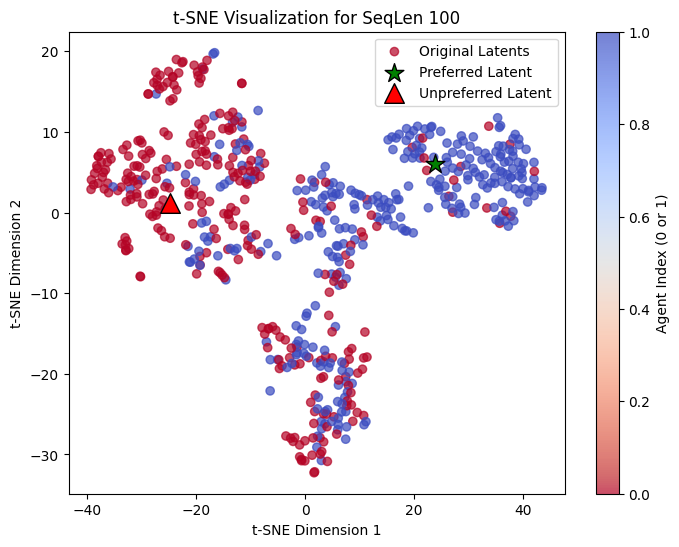

In [21]:
show_tsne_withlatents(capacity_inference, seqLen=100, train_set=train_set,use_src_mask=False)

(618, 16)


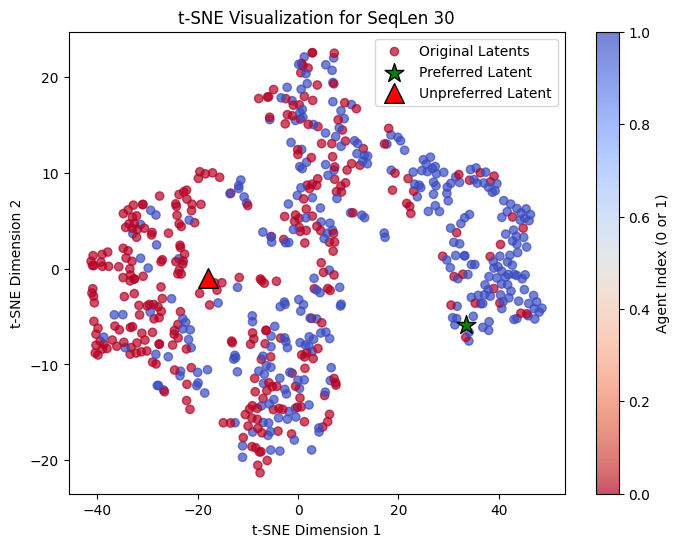

In [22]:
show_tsne_withlatents(capacity_inference, seqLen=30, train_set=train_set,use_src_mask=False)

### Use src_mask=False and causal_pool2=True, seqLenList=[10,30]

In [37]:
capacityEncoderFilepath='/mnt/vast-react/projects/rl_pref_constraint/PbRL/hopper-medium-replay-v2/CapacityEncoder/Percent100_05False/seed42/2025.03.26_174416'
capacity_inference, train_set, allAgentLatents=get_models_and_latents(capacityEncoderFilepath,seqLenList=[10,30,100])

Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 618 and test set size is 0


(618, 16)


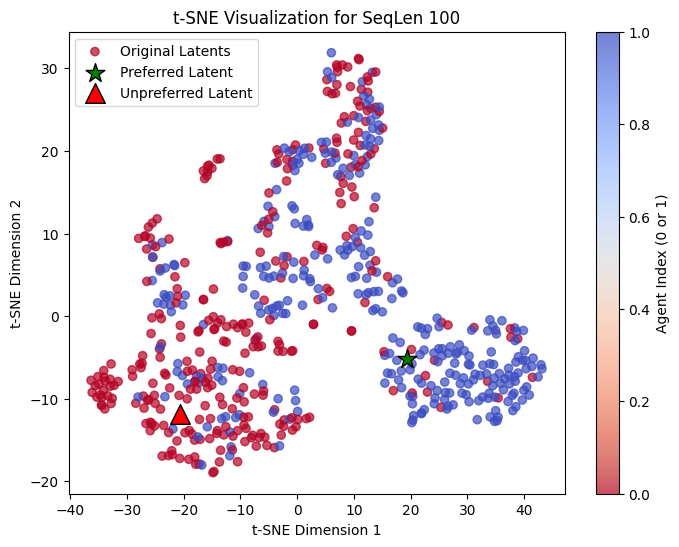

In [38]:
show_tsne_withlatents(capacity_inference, seqLen=100, train_set=train_set,use_src_mask=False)

(618, 16)


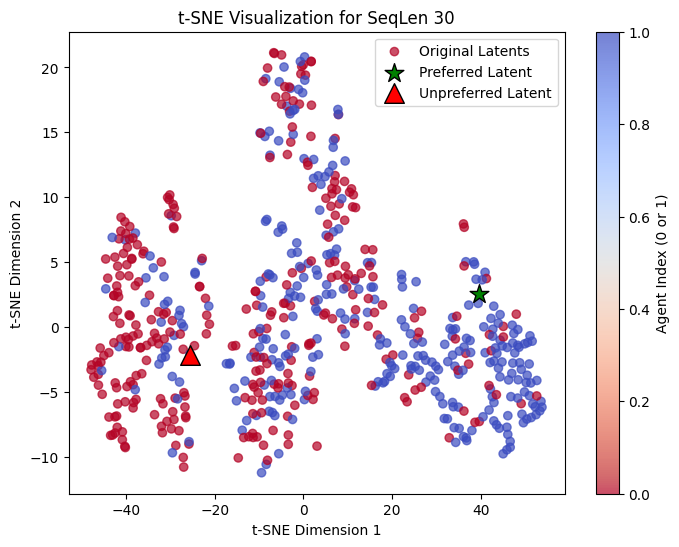

In [39]:
show_tsne_withlatents(capacity_inference, seqLen=30, train_set=train_set,use_src_mask=False)

(618, 16)


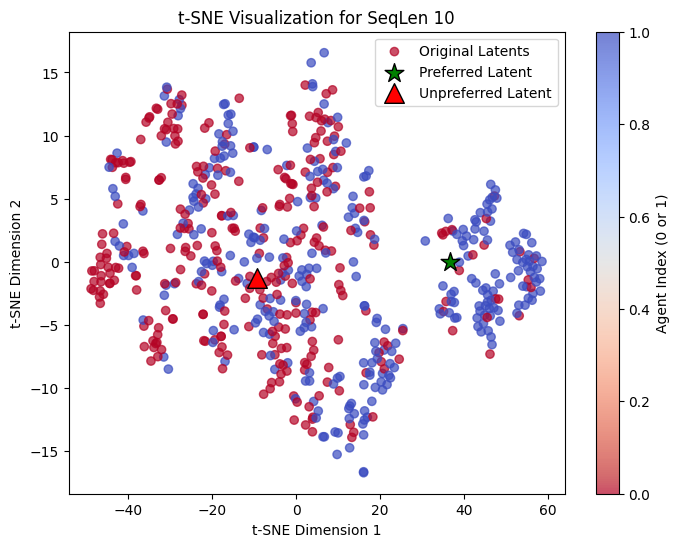

In [40]:
show_tsne_withlatents(capacity_inference, seqLen=10, train_set=train_set,use_src_mask=False)

## Reward Distribution Correlations and Outliers

### Hopper Medium Replay v2 Percent 100_05True

In [8]:
gtData=get_groundtruth_data('hopper-medium-replay-v2')
project='IQL_hopper-medium-replay-v2'

group='Percent100_05True_PreferenceTransformer'
job_type=None
ptData42=get_PT_data(project,group,job_type,seed=42)


group='Percent100_05True_PreferenceTransformer'
job_type=None
ptData93=get_PT_data(project,group,job_type,seed=93)

group='Percent100_05True_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
simData42=get_sim_dataset(project,group,job_type,seed=42)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.11it/s]


2039


/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed42_2025.03.13_051738


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 59055.12it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed93_2025.03.13_012544


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 51572.01it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


seed42_2025.03.30_100119


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:07<00:00, 274.85it/s]


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 1000 and test set size is 0


/user/rajaram/u13657/rltransfer/url_benchmark/pbrl/CottonDecoderV2pbrl.py:109: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  cumulative_sum = torch.cumsum(embed, dim=1)  # Shape: (batch_size, max_len, d_model)
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 53088.83it/s]


In [82]:
compute_correlations_outliers(ptData42,gtData)

((0.04453728229793881, 1.9993834040355656e-175),
 (-0.15780132804602015, 0.0),
 0.0,
 0.07278422701308274)

In [83]:
compute_correlations_outliers(ptData93,gtData)

((0.010467679790504784, 3.273437671781673e-11),
 (-0.08963637409960903, 0.0),
 0.0,
 0.07038381665247337)

In [84]:
compute_correlations_outliers(simData42,gtData)

((0.19836261188277013, 0.0), (0.2229962991563047, 0.0), 0.0, 0.0)

### Script Labels hopper-medium-replay-v2 Percent100_05True

In [85]:
gtData=get_groundtruth_data('hopper-medium-replay-v2')

project='IQL_hopper-medium-replay-v2_scriptLabel'

group='Percent100_05True_scriptLabel_PreferenceTransformer'
job_type=None
ptDataScript=get_PT_data(project,group,job_type,seed=42)

group='Percent100_05True_scriptLabel_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
simDataScript=get_sim_dataset(project,group,job_type,seed=42)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.19it/s]


2039


/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed42_2025.03.28_040204


chunk trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 51794.39it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


seed42_2025.03.29_231716


chunk trajectories: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:07<00:00, 262.74it/s]


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 1000 and test set size is 0


/user/rajaram/u13657/rltransfer/url_benchmark/pbrl/CottonDecoderV2pbrl.py:109: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  cumulative_sum = torch.cumsum(embed, dim=1)  # Shape: (batch_size, max_len, d_model)
chunk trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 54125.02it/s]


In [86]:
compute_correlations_outliers(ptDataScript,gtData)

((0.8058034732511029, 0.0),
 (0.8182457634869794, 0.0),
 0.20936359244816957,
 0.0)

In [87]:
compute_correlations_outliers(simDataScript,gtData)

((0.7166931666147681, 0.0), (0.7615761740200031, 0.0), 0.0, 0.0)

## Reward Distributions

### Hopper Medium Replay v2 Percent 100_05True

In [49]:
gtRewards=get_ground_truth_rewards('hopper-medium-replay-v2')

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.65it/s]


In [55]:
group='Percent100_05True_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
simRewards93=get_simRewards(project,group,job_type,seed=93)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


seed93_2025.03.30_100133


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:19<00:00, 107.01it/s]


Random seed set as 93
#######Using preloaded train/test sets#######
Input train set size 1000 and test set size is 0


/user/rajaram/u13657/rltransfer/url_benchmark/pbrl/CottonDecoderV2pbrl.py:109: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  cumulative_sum = torch.cumsum(embed, dim=1)  # Shape: (batch_size, max_len, d_model)
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 21323.96it/s]


In [52]:
project='IQL_hopper-medium-replay-v2'
group='Percent100_05True_PreferenceTransformer'
job_type=None
prefTransRewards93=return_PT_rewards(project,group,job_type,seed=93)

group='Percent100_05True_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
simRewards42=get_simRewards(project,group,job_type,seed=42)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed93_2025.03.13_012544


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 23038.24it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


seed42_2025.03.30_100119


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 107.71it/s]


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 1000 and test set size is 0


/user/rajaram/u13657/rltransfer/url_benchmark/pbrl/CottonDecoderV2pbrl.py:109: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  cumulative_sum = torch.cumsum(embed, dim=1)  # Shape: (batch_size, max_len, d_model)
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 22346.97it/s]


In [43]:
project='IQL_hopper-medium-replay-v2'

group='Percent100_05True_PreferenceTransformer'
job_type=None
prefTransRewards42=return_PT_rewards(project,group,job_type,seed=42)



/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed42_2025.03.13_051738


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 22607.25it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed93_2025.03.13_012544


relabel reward:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 949/1569 [07:39<04:59,  2.07it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Rewards Histogram')

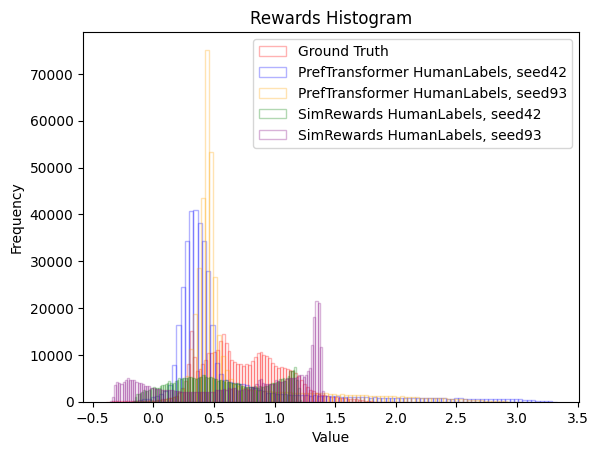

In [58]:
# Plot the histogram
bins=100
labelModifier='HumanLabels'
plt.hist(gtRewards, bins=bins, label='Ground Truth', edgecolor='red',fill=False,alpha=.3)
plt.hist(prefTransRewards42, bins=bins, label='PrefTransformer {}, seed42'.format(labelModifier), edgecolor='blue',fill=False,alpha=.3)
plt.hist(prefTransRewards93, bins=bins, label='PrefTransformer {}, seed93'.format(labelModifier), edgecolor='orange',fill=False,alpha=.3)
#plt.hist(simRewardsBad, bins=bins, label='Bad Rewards',edgecolor='green',fill=False)
plt.hist(simRewards42, bins=bins, label='SimRewards {}, seed42'.format(labelModifier),edgecolor='green',fill=False,alpha=.3)
plt.hist(simRewards93, bins=bins, label='SimRewards {}, seed93'.format(labelModifier),edgecolor='purple',fill=False,alpha=.3)


# Labels and title
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Rewards Histogram")

### Script Labels hopper-medium-replay-v2 Percent100_05True

Why is the IQL result for hopper so bad with PT when using script labels?

In [30]:
project='IQL_hopper-medium-replay-v2_scriptLabel'

group='Percent100_05True_scriptLabel_PreferenceTransformer'
job_type=None
ptRewards=return_PT_rewards(project,group,job_type,seed=42)

group='Percent100_05True_scriptLabel_SimilarityRewards'
job_type='NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs'
simRewards=get_simRewards(project,group,job_type,seed=42)

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


seed42_2025.03.28_040204


chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 25270.77it/s]
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


seed42_2025.03.29_231716


chunk trajectories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:18<00:00, 108.04it/s]


Random seed set as 42
#######Using preloaded train/test sets#######
Input train set size 1000 and test set size is 0


/user/rajaram/u13657/rltransfer/url_benchmark/pbrl/CottonDecoderV2pbrl.py:109: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  cumulative_sum = torch.cumsum(embed, dim=1)  # Shape: (batch_size, max_len, d_model)
chunk trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 23708.92it/s]


In [31]:
gtRewards=get_ground_truth_rewards('hopper-medium-replay-v2')

/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/user/rajaram/u13657/.local/lib/python3.10/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.89it/s]


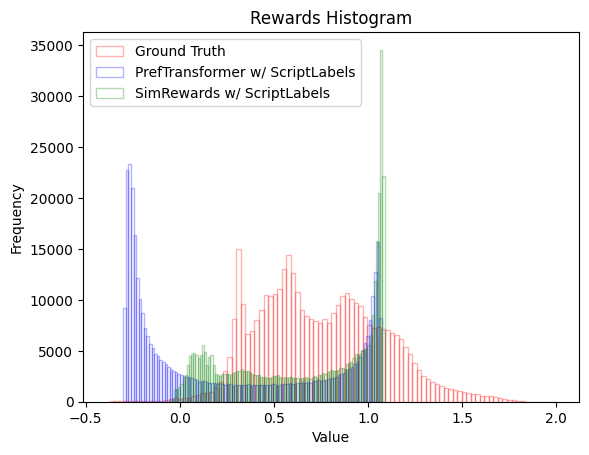

In [51]:
plot_reward_dist(gtRewards,ptRewards,simRewards,labelModifier='w/ ScriptLabels')

## Plotting from Wandb Runs

In [4]:
import wandb
import numpy as np
import matplotlib.pyplot as plt



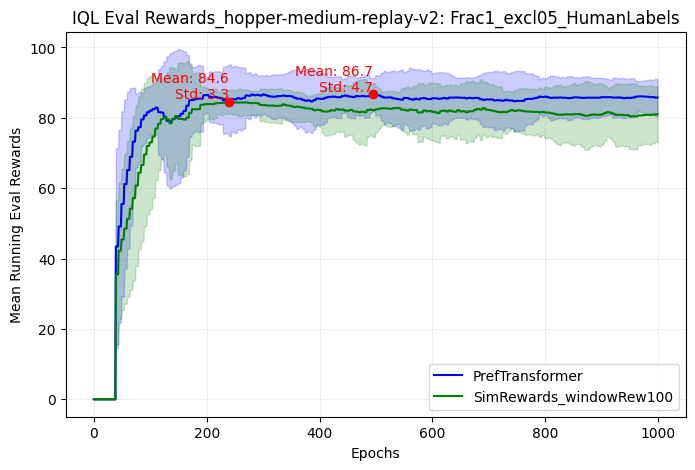

In [7]:
project='IQL_hopper-medium-replay-v2'
groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards_subseqsMore'),
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_seqLensCapEncAndIQL','SimRewards_subseqsLess'),]
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_windowRew100','SimRewards_windowRew100')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_excl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title,colors=['b','g'])

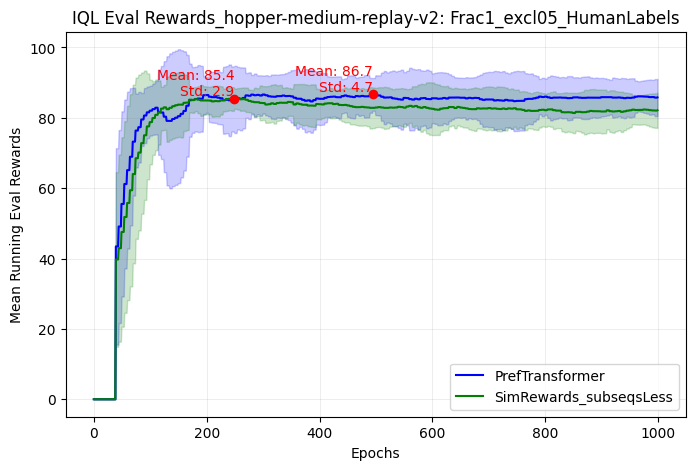

In [6]:
project='IQL_hopper-medium-replay-v2'
groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards_subseqsMore'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_seqLensCapEncAndIQL','SimRewards_subseqsLess'),]
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_windowRew100','SimRewards_windowRew100')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_excl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title,colors=['b','g'])

In [ ]:
project='IQL_hopper-medium-replay-v2'
#groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),

groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards_subseqsMore'),]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_excl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title,colors=['b', 'g'])

85.3183580242238, 4.69376426894628
85.44642509994674, 2.8723139552405694
84.19879745343498, 2.826356522136444
84.62784374310152, 3.334602575323419
84.1712521832619, 7.842296479816468


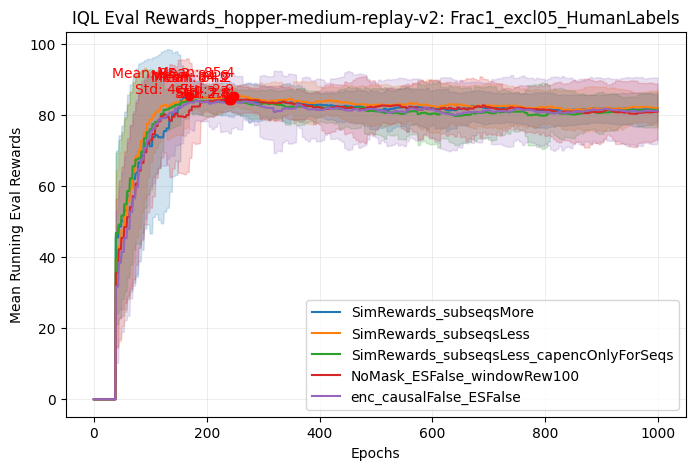

In [36]:
project='IQL_hopper-medium-replay-v2'
#groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
groupInfos=[('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards_subseqsMore'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL','SimRewards_subseqsLess'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_seqLens','SimRewards_subseqsLess_capencOnlyForSeqs'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_windowRew100','NoMask_ESFalse_windowRew100',),
    ('Percent100_05False_SimilarityRewards','enc_causalFalse_ESFalse','enc_causalFalse_ESFalse')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_excl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title,colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

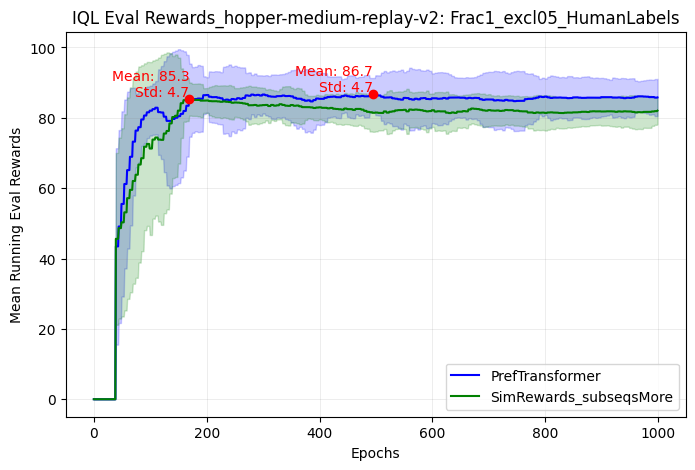

In [5]:
project='IQL_hopper-medium-replay-v2'
groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards_subseqsMore'),]
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_seqLensCapEncAndIQL','SimRewards_subseqsLess'),
    #('Percent100_05False_SimilarityRewards','NoMask_ESFalse_windowRew100','SimRewards_windowRew100')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_excl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title,colors=['b','g'])


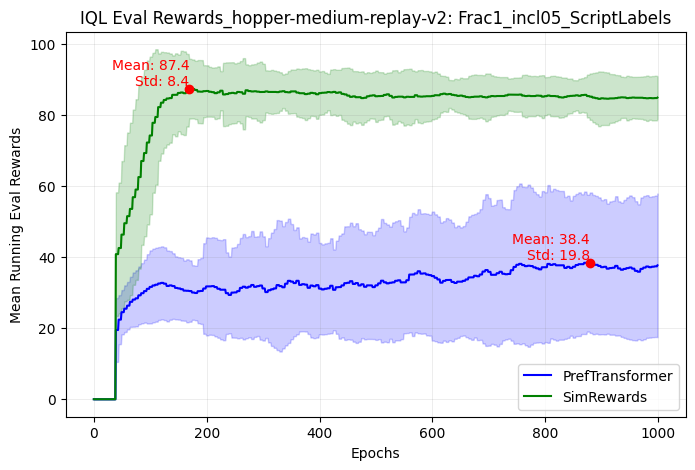

In [106]:


groupInfos=[('Percent100_05True_scriptLabel_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05True_scriptLabel_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_incl05_ScriptLabels'
plot_stats_over_groups(project,groupInfos,title=title)


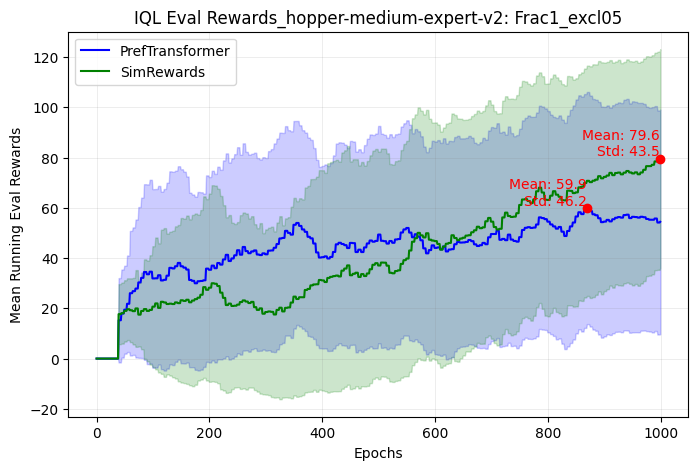

In [18]:
project='IQL_hopper-medium-expert-v2'
groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards')]
title='IQL Eval Rewards_hopper-medium-expert-v2: Frac1_excl05'
plot_stats_over_groups(project,groupInfos,title=title)

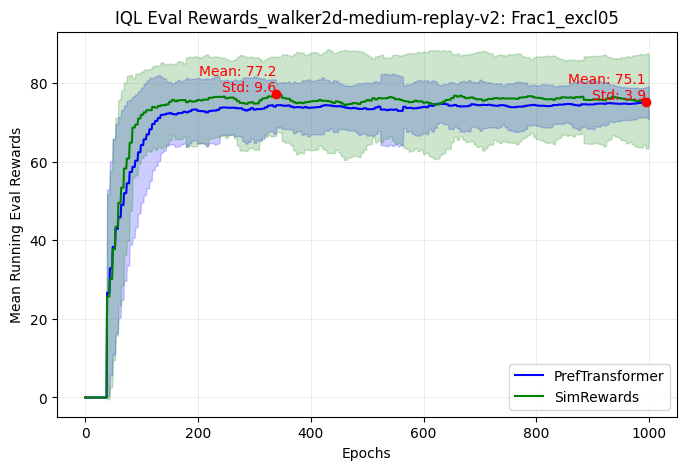

In [19]:
project='IQL_walker2d-medium-replay-v2'
groupInfos=[('Percent100_05False_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SimRewards')]
title='IQL Eval Rewards_walker2d-medium-replay-v2: Frac1_excl05'
plot_stats_over_groups(project,groupInfos,title=title)

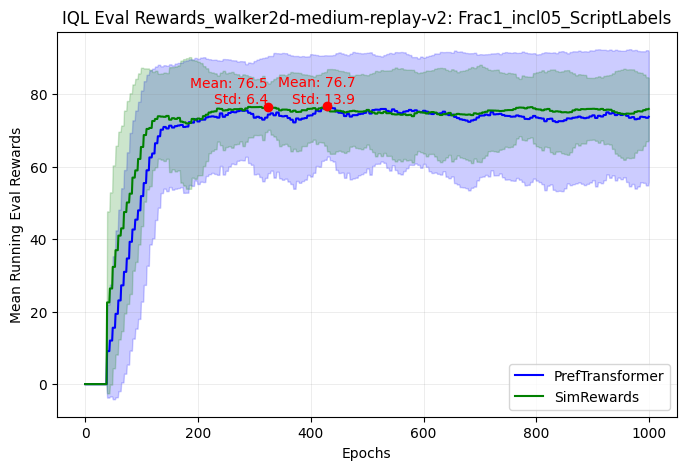

In [30]:
project='IQL_walker2d-medium-replay-v2_scriptLabel'
groupInfos=[('Percent100_05True_scriptLabel_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05True_scriptLabel_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SimRewards')]
title='IQL Eval Rewards_walker2d-medium-replay-v2: Frac1_incl05_ScriptLabels'
plot_stats_over_groups(project,groupInfos,title=title)

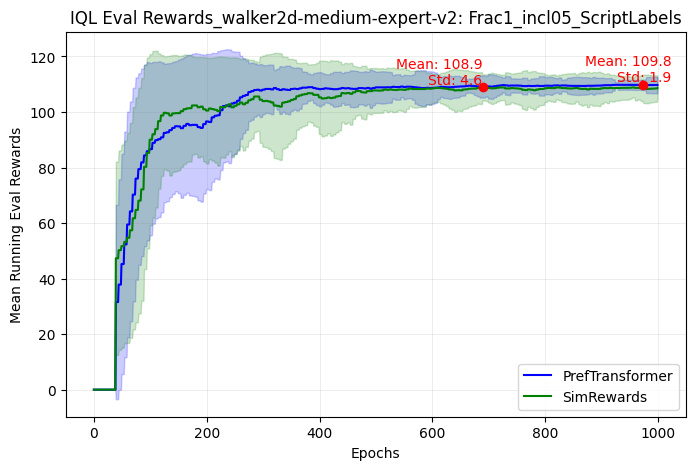

In [31]:
project='IQL_walker2d-medium-expert-v2_scriptLabel'
groupInfos=[('Percent100_05True_scriptLabel_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05True_scriptLabel_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SimRewards')]
title='IQL Eval Rewards_walker2d-medium-expert-v2: Frac1_incl05_ScriptLabels'
plot_stats_over_groups(project,groupInfos,title=title)

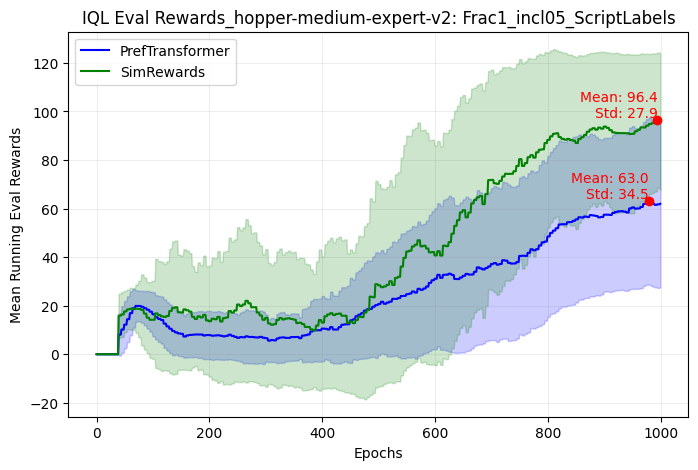

In [20]:
project='IQL_hopper-medium-expert-v2_scriptLabel'
groupInfos=[('Percent100_05True_scriptLabel_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05True_scriptLabel_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SimRewards')]
title='IQL Eval Rewards_hopper-medium-expert-v2: Frac1_incl05_ScriptLabels'
plot_stats_over_groups(project,groupInfos,title=title)

In [57]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

def plot_stats_over_groups(project,groupInfos,colors=['b','g'],title=''):
    plt.figure(figsize=(8, 5))
    for idx,groupInfo in enumerate(groupInfos):
        group,job_type,label=groupInfo
        get_stats_over_seeds(project,group,job_type,color=colors[idx],title=title,label=label)
    
    plt.xlabel("Epochs")
    plt.ylabel("Running Mean Eval Rewards")
    plt.title(title)
    plt.legend()
    plt.grid(color='gray', linewidth=0.5, alpha=0.2)
    plt.show()

def get_stats_over_seeds(project,group,job_type,color='b',title='',label=''):

    plt.rcParams.update({
        "text.usetex": False,            # use mathtext, no external LaTeX
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],  # ensure a real installed serif
        "mathtext.fontset": "cm",        # Computer Modern for math
        "font.size": 10,
        "axes.titlesize": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 12,
    })
    # Fetch runs from the specific project and group
    api = wandb.Api()
    runs = api.runs(
        f"{project}",
        filters={"group": group, "jobType": job_type}
    )

    # Extract data
    num_seeds = len(runs)  # Number of seeds (each run is one seed)
    if num_seeds!=8:
        raise ValueError("{}/{}/{} should have 8 seeds".format(project,group,job_type))
    all_means = []  # Stores mean rewards for each seed
    all_stds = []  # Stores std deviations for each seed

    for run in runs:
        # Use scan_history() to fetch **full** history without sampling
        mean_rewards = []
        std_rewards = []
        for row in run.scan_history():
            if row["eval/running_epRewards_mean"] is not None and row["eval/running_epRewards_std"] is not None:
                mean_rewards.append(row["eval/running_epRewards_mean"])  #
                std_rewards.append(row["eval/running_epRewards_std"])  
        
        all_means.append(mean_rewards)
        all_stds.append(std_rewards)

    # Convert lists to numpy arrays
    all_means = np.array(all_means)  # Shape: (num_seeds, num_epochs)
    all_stds = np.array(all_stds)  # Shape: (num_seeds, num_epochs)

    # Compute mean across seeds
    mean_across_seeds = np.mean(all_means, axis=0)

    # Compute total standard deviation
    all_stds_corrected=all_stds*np.sqrt(80/79) #minor correction factor since we had logged runs with ddof=0 (the default for np.std)
    within_seed_var = np.mean(all_stds_corrected ** 2, axis=0)  # Expectation of within-seed variance
    across_seed_var = np.var(all_means, axis=0, ddof=1)  # Variance of means across seeds
    total_std = np.sqrt(within_seed_var + across_seed_var)  # Combined std

    # Get x-axis (epochs)
    num_epochs = all_means.shape[1]
    print(num_epochs)
    if num_epochs==200: # we changed reward evaluation to do every 5 epochs, so this adjusts for that
        epochs = np.arange(0, 1000, 5)
        print(len(epochs))
    else:
        epochs = np.arange(0, num_epochs) 

    # Find the epoch where mean_across_seeds is max
    max_idx = np.argmax(mean_across_seeds)
    max_epoch = epochs[max_idx]
    max_value = mean_across_seeds[max_idx]
    max_std = total_std[max_idx]

    # Plot
    
    plt.plot(epochs, mean_across_seeds, color=color,label=label)
    plt.fill_between(epochs, mean_across_seeds - total_std, 
                    mean_across_seeds + total_std, color=color, alpha=0.2)

    # Mark the max point
    # if group=='GroundTruth':
    #     offset=-5
    # elif group=='Percent100_05False_modForWalker_SimilarityRewards':
    #     offset=1.0
    # elif group=='Percent100_05False_SimilarityRewards':
    #     offset=5.0
    # else:
    #     offset=0.0
    # plt.scatter([max_epoch], [max_value], color='black', zorder=3)
    # plt.text(max_epoch, max_value+offset, 
    # f"Mean: {max_value:.1f}\nStd: {max_std:.1f}", 
    # fontsize=10, color='black', ha='right', va='bottom')
    print('{}, {}'.format(max_value,max_std))




<>:3: DeprecationWarning: invalid escape sequence '\m'
<>:4: DeprecationWarning: invalid escape sequence '\m'
<>:3: DeprecationWarning: invalid escape sequence '\m'
<>:4: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_24/2862780000.py:3: DeprecationWarning: invalid escape sequence '\m'
  ('Percent100_05False_modForWalker_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SARA with hopper replay $\mathcal{D}_{pref}$ + IQL'),
/tmp/ipykernel_24/2862780000.py:4: DeprecationWarning: invalid escape sequence '\m'
  ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_RandomSubseqs','SARA with walker replay $\mathcal{D}_{pref}$ + IQL')


200
200
77.53367886691682, 15.499185254737885
1000
74.98995086866147, 7.884730772190481
1000
77.90804029576736, 7.199629017014534


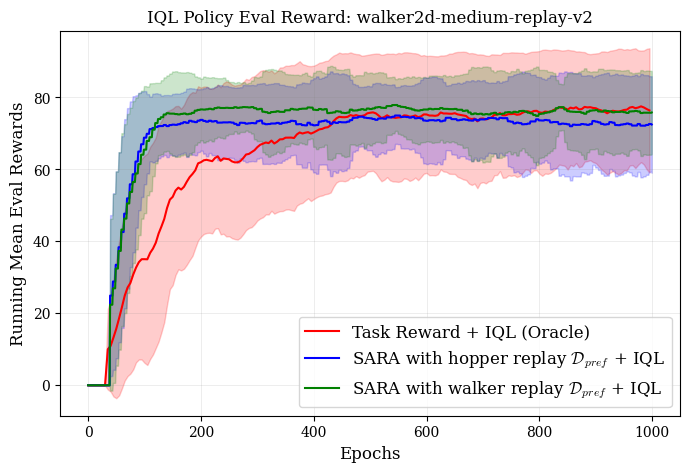

In [58]:
project='IQL_walker2d-medium-replay-v2'
groupInfos=[('GroundTruth',"NewNorm",'Task Reward + IQL (Oracle)'),
    ('Percent100_05False_modForWalker_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SARA with hopper replay $\mathcal{D}_{pref}$ + IQL'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_RandomSubseqs','SARA with walker replay $\mathcal{D}_{pref}$ + IQL')
    ]
title='IQL Policy Eval Reward: walker2d-medium-replay-v2'
plot_stats_over_groups(project,groupInfos,colors=['r','b','g'],title=title)

<>:3: DeprecationWarning: invalid escape sequence '\m'
<>:4: DeprecationWarning: invalid escape sequence '\m'
<>:3: DeprecationWarning: invalid escape sequence '\m'
<>:4: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_30/59260865.py:3: DeprecationWarning: invalid escape sequence '\m'
  ('Percent100_05False_modForWalker_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SARA with hopper replay $\mathcal{D}_{pref}$ + IQL'),
/tmp/ipykernel_30/59260865.py:4: DeprecationWarning: invalid escape sequence '\m'
  ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_RandomSubseqs','SARA with walker replay $\mathcal{D}_{pref}$ + IQL')


70.14984551742079, 22.068256822448486
74.98995086866147, 7.884730772190481
77.90804029576736, 7.199629017014534


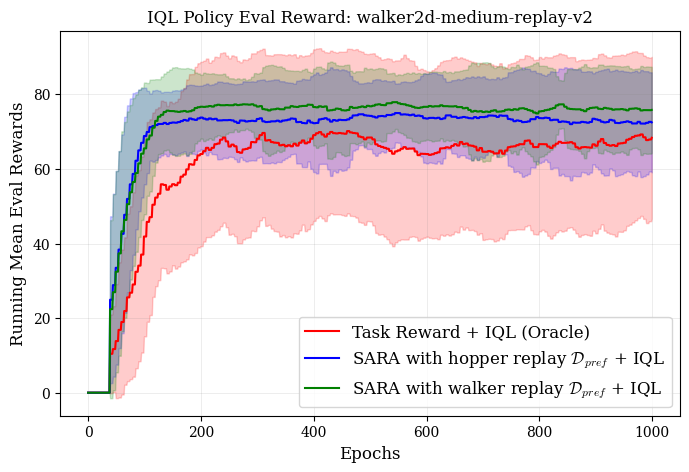

In [83]:
project='IQL_walker2d-medium-replay-v2'
groupInfos=[('GroundTruth',None,'Task Reward + IQL (Oracle)'),
    ('Percent100_05False_modForWalker_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_moreSeqs','SARA with hopper replay $\mathcal{D}_{pref}$ + IQL'),
    ('Percent100_05False_SimilarityRewards','NoMask_ESFalse_NoSrc_cpTrue_RandomSubseqs','SARA with walker replay $\mathcal{D}_{pref}$ + IQL')
    ]
title='IQL Policy Eval Reward: walker2d-medium-replay-v2'
plot_stats_over_groups(project,groupInfos,colors=['r','b','g'],title=title)

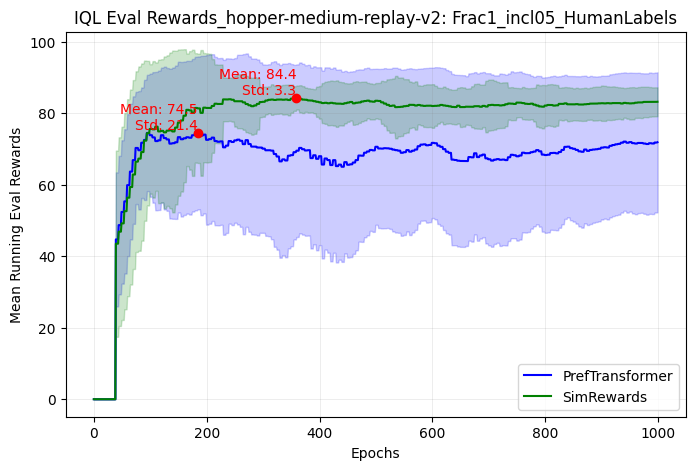

In [40]:
project='IQL_hopper-medium-replay-v2'
groupInfos=[('Percent100_05True_PreferenceTransformer',None,'PrefTransformer'),
    ('Percent100_05True_SimilarityRewards','NoMask_ESFalse_NoSrc_causalpoolTrue_SeqLensCapEncAndIQL_moreSeqs','SimRewards')]
title='IQL Eval Rewards_hopper-medium-replay-v2: Frac1_incl05_HumanLabels'
plot_stats_over_groups(project,groupInfos,title=title)

## Cherry Picking Best Trajectories

In [4]:
kHighest=50

use05=False
task='hopper-medium-replay-v2'
train_split_size=.8
data_seed=3407

In [5]:
def get_trajs_preferred_fromInds(indsToKeep,obsKey,actionKey,rewardKey):
    prefObs=torch.tensor(preference_set[obsKey][indsToKeep])
    prefAction=torch.tensor(preference_set[actionKey][indsToKeep])
    totalRewards=preference_set[rewardKey][indsToKeep].sum(1)
    maskShape=prefObs.shape[:-1]
    src_key_padding_mask=torch.zeros(maskShape,dtype=torch.bool).unsqueeze(2) # assumed not truncating, so set to False. Both trajs use the same mask (all False anyway)
    prefAgIdx=torch.zeros(prefObs.shape[:-1])+1
    prefAgIdx=prefAgIdx.unsqueeze(2)
    trajsPreferred=torch.cat([prefObs,prefAction,src_key_padding_mask, prefAgIdx],dim=2) #numTrajectories x stepMax(100) x obsDim+actionDim+3 (mask+agentId+taskId)
    return trajsPreferred,torch.tensor(totalRewards)

In [6]:
#after creating the preferred set, iterate through all totalRewards0 and totalRewards1 in the original preference_set. If any of those rewards< the rewards in prefRewards, add the corresponding observation/action (or observation_2, action_2) to the unpreferred set
def get_trajs_unpref(rewardsArr,obsKey,actionKey,prefRewards):
    indsUnpref=[]
    for i,rew in enumerate(rewardsArr):
        is_less_than_all = (rew < prefRewards).all().item()
        if is_less_than_all:
            indsUnpref.append(i)
        
    unprefObs=torch.tensor(preference_set[obsKey][indsUnpref])
    unprefAction=torch.tensor(preference_set[actionKey][indsUnpref])
    maskShape=unprefObs.shape[:-1]
    src_key_padding_mask=torch.zeros(maskShape,dtype=torch.bool).unsqueeze(2)
    unprefAgIdx=torch.zeros(unprefObs.shape[:-1]).unsqueeze(2)
    trajsUnpreferred=torch.cat([unprefObs,unprefAction,src_key_padding_mask, unprefAgIdx],dim=2) 
    return trajsUnpreferred


#### Create Dataset CP52

In [145]:


#def get_highest_rewards(task,use05,kHighest=100):
save_dir='/mnt/vast-react/projects/rl_pref_constraint/PbRL'
dataset_name='Percent{}_05{}'.format(100,use05)
data_dir=os.path.join(save_dir,task,'Data',dataset_name)
with open(os.path.join(data_dir,'preference_dataset.pkl'), 'rb') as f:
    preference_set = pickle.load(f) 
totalRewards0=preference_set['rewards'].sum(1)
totalRewards1=preference_set['rewards_2'].sum(1)
labels=np.array(preference_set['labels'])

top_indices = np.argpartition(totalRewards0, -kHighest)[-kHighest:]
top_0 = top_indices[np.argsort(totalRewards0[top_indices])[::-1]] #indices of top k rewards
print(top_0)
print(totalRewards0[top_0])

labels_top_0=labels[top_0] #the labels at the top k rewards
print(labels_top_0)
matches = np.all(labels_top_0 == np.array([1,0]), axis=1) 
labelAgreeing_indices0 = np.where(matches)[0] #indices where the top k rewards have labels agreeing with this preferred trajectory
print(totalRewards0[top_0[labelAgreeing_indices0]]) #the ground truth rewards at these indices
indsToKeep0=top_0[labelAgreeing_indices0]


print("###############")

top_indices = np.argpartition(totalRewards1, -kHighest)[-kHighest:]
top_1 = top_indices[np.argsort(totalRewards1[top_indices])[::-1]]
print(top_1)
print(totalRewards1[top_1]) 
labels_top_1=labels[top_1] #the labels at the top k rewards
print(labels_top_1)
matches = np.all(labels_top_1 == np.array([0,1]), axis=1) 
labelAgreeing_indices1 = np.where(matches)[0] #indices where the top k rewards have labels agreeing with this preferred trajectory
print(totalRewards1[top_1[labelAgreeing_indices1]]) #the ground truth rewards at these indices
indsToKeep1=top_1[labelAgreeing_indices1]

#create preferred set for my similarity rewards training set. Get the observations, actions at indsToKeep0. Create a separate list of the rewards at indsToKeep0
trajsPref0,prefRewards0=get_trajs_preferred_fromInds(indsToKeep0,'observations','actions','rewards')
#create preferred set for my similarity rewards training set. Get the observations_2, actions_2 at indsToKeep1. Create a separate list of rewards at indsToKeep1. 
trajsPref1,prefRewards1=get_trajs_preferred_fromInds(indsToKeep1,'observations_2','actions_2','rewards_2')
#concatenate from both inds:
trajsPref=torch.cat([trajsPref0,trajsPref1],dim=0)
prefRewards=torch.cat([prefRewards0,prefRewards1])


  

[169  45 127 299 187  38 300  24 179 241 249 287 171 148 124 262  66 145
 214 208 304 211  57 105  12 268  64 132 159 216 308  76  75 184 152  34
 239 286  82 283  63  67 261 291  59 168 182   5 294  42]
[423.242136   418.71338081 416.58749104 409.14178085 402.38793266
 401.84564447 397.44819164 396.02111149 393.7636292  391.9782095
 391.94340134 389.36872971 388.3008132  385.39808249 384.76600885
 381.75764465 375.84378028 374.43156695 370.73596549 370.32647848
 369.93391418 366.21655345 362.58018255 361.53317499 361.04859543
 358.82836962 357.51414585 357.28421605 356.54569697 355.81529701
 351.55156469 350.3956883  348.74055696 347.49702144 347.29272294
 346.54745579 341.90204954 341.24735343 341.17869055 340.44137645
 339.99328756 339.84796524 339.42138648 339.04152369 336.75996852
 334.81950498 333.62783504 332.22116137 331.75961375 330.0841862 ]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [ ]:
#after creating the preferred set, iterate through all totalRewards0 and totalRewards1 in the original preference_set. If any of those rewards< the rewards in prefRewards, add the corresponding observation/action (or observation_2, action_2) to the unpreferred set
trajsUnpreferred0=get_trajs_unpref(totalRewards0,'observations','actions',prefRewards)
trajsUnpreferred1=get_trajs_unpref(totalRewards1,'observations_2','actions_2',prefRewards)
trajsUnpreferred=torch.cat([trajsUnpreferred0,trajsUnpreferred1],dim=0)

all_trajectories=torch.cat([trajsPref,trajsUnpreferred],dim=0)
all_trajectories=all_trajectories[torch.randperm(all_trajectories.size()[0])]
all_trajectories=all_trajectories.float()


if train_split_size<1.0:
    train_set, test_set = train_test_split(all_trajectories, train_size=train_split_size, shuffle=True, random_state=data_seed)
else:
    train_set=all_trajectories
    test_set=[]


combined = np.sort(np.concatenate([indsToKeep0, indsToKeep1]))
pref_set_cherryPicked={}
for key in preference_set:
    pref_set_cherryPicked[key]=preference_set[key][combined]

print('Num preference queries {}'.format(pref_set_cherryPicked['observations'].shape[0]))
print("Train set size {}".format(len(train_set)))
print("Test set size {}".format(len(test_set)))

In [154]:

pref_eval_set_cherryPicked={}
numQueries=pref_set_cherryPicked['labels'].shape[0]
numEval=int(numQueries*.1)
indsEval = random.sample(range(numQueries), numEval)

for key in pref_set_cherryPicked:
    pref_eval_set_cherryPicked[key]=pref_set_cherryPicked[key][indsEval]


In [157]:
folderName='Percent100_05False_cp52'#CHANGE as needed
save_dir=os.path.join(save_dir,task,'Data',folderName)
os.makedirs(save_dir,exist_ok=True)
with open(os.path.join(save_dir,'train_set.pkl'), 'wb') as f:  # open a text file
    pickle.dump(train_set, f)
with open(os.path.join(save_dir,'test_set.pkl'), 'wb') as f:  # open a text file
    pickle.dump(test_set, f)
with open(os.path.join(save_dir,'preference_dataset.pkl'), 'wb') as f:  # open a text file
    pickle.dump(pref_set_cherryPicked, f)
with open(os.path.join(save_dir,'pref_eval_dataset_{}.pkl'.format(False)), 'wb') as f:  # open a text file
    pickle.dump(pref_eval_set_cherryPicked, f)

#### Create With Balanced Train Set

In [7]:


#def get_highest_rewards(task,use05,kHighest=100):
save_dir='/mnt/vast-react/projects/rl_pref_constraint/PbRL'
dataset_name='Percent{}_05{}'.format(100,use05)
data_dir=os.path.join(save_dir,task,'Data',dataset_name)
with open(os.path.join(data_dir,'preference_dataset.pkl'), 'rb') as f:
    preference_set = pickle.load(f) 
totalRewards0=preference_set['rewards'].sum(1)
totalRewards1=preference_set['rewards_2'].sum(1)
labels=np.array(preference_set['labels'])

top_indices = np.argpartition(totalRewards0, -kHighest)[-kHighest:]
top_0 = top_indices[np.argsort(totalRewards0[top_indices])[::-1]] #indices of top k rewards
print(top_0)
print(totalRewards0[top_0])

labels_top_0=labels[top_0] #the labels at the top k rewards
print(labels_top_0)
matches = np.all(labels_top_0 == np.array([1,0]), axis=1) 
labelAgreeing_indices0 = np.where(matches)[0] #indices where the top k rewards have labels agreeing with this preferred trajectory
print(totalRewards0[top_0[labelAgreeing_indices0]]) #the ground truth rewards at these indices
indsToKeep0=top_0[labelAgreeing_indices0]


print("###############")

top_indices = np.argpartition(totalRewards1, -kHighest)[-kHighest:]
top_1 = top_indices[np.argsort(totalRewards1[top_indices])[::-1]]
print(top_1)
print(totalRewards1[top_1]) 
labels_top_1=labels[top_1] #the labels at the top k rewards
print(labels_top_1)
matches = np.all(labels_top_1 == np.array([0,1]), axis=1) 
labelAgreeing_indices1 = np.where(matches)[0] #indices where the top k rewards have labels agreeing with this preferred trajectory
print(totalRewards1[top_1[labelAgreeing_indices1]]) #the ground truth rewards at these indices
indsToKeep1=top_1[labelAgreeing_indices1]

#create preferred set for my similarity rewards training set. Get the observations, actions at indsToKeep0. Create a separate list of the rewards at indsToKeep0
trajsPref0,prefRewards0=get_trajs_preferred_fromInds(indsToKeep0,'observations','actions','rewards')
#create preferred set for my similarity rewards training set. Get the observations_2, actions_2 at indsToKeep1. Create a separate list of rewards at indsToKeep1. 
trajsPref1,prefRewards1=get_trajs_preferred_fromInds(indsToKeep1,'observations_2','actions_2','rewards_2')
#concatenate from both inds:
trajsPref=torch.cat([trajsPref0,trajsPref1],dim=0)
prefRewards=torch.cat([prefRewards0,prefRewards1])




[169  45 127 299 187  38 300  24 179 241 249 287 171 148 124 262  66 145
 214 208 304 211  57 105  12 268  64 132 159 216 308  76  75 184 152  34
 239 286  82 283  63  67 261 291  59 168 182   5 294  42]
[423.242136   418.71338081 416.58749104 409.14178085 402.38793266
 401.84564447 397.44819164 396.02111149 393.7636292  391.9782095
 391.94340134 389.36872971 388.3008132  385.39808249 384.76600885
 381.75764465 375.84378028 374.43156695 370.73596549 370.32647848
 369.93391418 366.21655345 362.58018255 361.53317499 361.04859543
 358.82836962 357.51414585 357.28421605 356.54569697 355.81529701
 351.55156469 350.3956883  348.74055696 347.49702144 347.29272294
 346.54745579 341.90204954 341.24735343 341.17869055 340.44137645
 339.99328756 339.84796524 339.42138648 339.04152369 336.75996852
 334.81950498 333.62783504 332.22116137 331.75961375 330.0841862 ]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [9]:
#almost the same as the preferred from inds function, except for agent index. Would feel in index0 with obs and aciton key 2
def get_trajs_unpreferred_fromInds(indsToKeep,obsKey,actionKey,rewardKey):
    obs=torch.tensor(preference_set[obsKey][indsToKeep])
    action=torch.tensor(preference_set[actionKey][indsToKeep])
    totalRewards=preference_set[rewardKey][indsToKeep].sum(1)
    maskShape=obs.shape[:-1]
    src_key_padding_mask=torch.zeros(maskShape,dtype=torch.bool).unsqueeze(2) # assumed not truncating, so set to False. Both trajs use the same mask (all False anyway)
    agIdx=torch.zeros(obs.shape[:-1])
    agIdx=agIdx.unsqueeze(2)
    trajs=torch.cat([obs,action,src_key_padding_mask, agIdx],dim=2) #numTrajectories x stepMax(100) x obsDim+actionDim+3 (mask+agentId+taskId)
    return trajs,torch.tensor(totalRewards)

In [10]:
#after creating the preferred set, iterate through all totalRewards0 and totalRewards1 in the original preference_set. If any of those rewards< the rewards in prefRewards, add the corresponding observation/action (or observation_2, action_2) to the unpreferred set
trajsUnpreferred0,rewardsUnpref0=get_trajs_unpreferred_fromInds(indsToKeep0,'observations_2','actions_2','rewards_2')
trajsUnpreferred1,rewardsUnpref1=get_trajs_unpreferred_fromInds(indsToKeep1,'observations','actions','rewards')
trajsUnpreferred=torch.cat([trajsUnpreferred0,trajsUnpreferred1],dim=0)

all_trajectories=torch.cat([trajsPref,trajsUnpreferred],dim=0)
all_trajectories=all_trajectories[torch.randperm(all_trajectories.size()[0])]
all_trajectories=all_trajectories.float()


if train_split_size<1.0:
    train_set, test_set = train_test_split(all_trajectories, train_size=train_split_size, shuffle=True, random_state=data_seed)
else:
    train_set=all_trajectories
    test_set=[]


combined = np.sort(np.concatenate([indsToKeep0, indsToKeep1]))
pref_set_cherryPicked={}
for key in preference_set:
    pref_set_cherryPicked[key]=preference_set[key][combined]

print('Num preference queries {}'.format(pref_set_cherryPicked['observations'].shape[0]))
print("Train set size {}".format(len(train_set)))
print("Test set size {}".format(len(test_set)))

Num preference queries 52
Train set size 83
Test set size 21


In [11]:
pref_eval_set_cherryPicked={}
numQueries=pref_set_cherryPicked['labels'].shape[0]
numEval=int(numQueries*.1)
indsEval = random.sample(range(numQueries), numEval)

for key in pref_set_cherryPicked:
    pref_eval_set_cherryPicked[key]=pref_set_cherryPicked[key][indsEval]

In [16]:
folderName='Percent100_05False_cp52_balancedForSim'#CHANGE as needed
save_dir=os.path.join(save_dir,task,'Data',folderName)
os.makedirs(save_dir,exist_ok=True)
with open(os.path.join(save_dir,'train_set.pkl'), 'wb') as f:  # open a text file
    pickle.dump(train_set, f)
with open(os.path.join(save_dir,'test_set.pkl'), 'wb') as f:  # open a text file
    pickle.dump(test_set, f)
with open(os.path.join(save_dir,'preference_dataset.pkl'), 'wb') as f:  # open a text file
    pickle.dump(pref_set_cherryPicked, f)
with open(os.path.join(save_dir,'pref_eval_dataset_{}.pkl'.format(False)), 'wb') as f:  # open a text file
    pickle.dump(pref_eval_set_cherryPicked, f)